In [5]:
# Import semua modul yang dibutuhkan
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np
import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from itertools import product

In [2]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Memuat dataset
df = pd.read_csv('C:/Users/ACER/Dokumen/sejarah emisi.csv', delimiter=';')

# Menampilkan 5 baris pertama dari dataset
df.head()

Country_Name Country         Source                 Sector      Gas  \
0  Afghanistan     AFG  Climate Watch   Total excluding LUCF  All GHG   
1  Afghanistan     AFG  Climate Watch   Total including LUCF  All GHG   
2  Afghanistan     AFG  Climate Watch                Energy   All GHG   
3  Afghanistan     AFG  Climate Watch  Industrial Processes   All GHG   
4  Afghanistan     AFG  Climate Watch           Agriculture   All GHG   

            1990           1991           1992           1993           1994  \
0  1162753596,00  1189739128,00  1154587129,00  1167762381,00  1173158672,00   
1  9238795265,00  9508650579,00  9157130593,00  9288883107,00  9342846021,00   
2  2280285183,00  2136022844,00  1681060505,00  1644098166,00  1570135827,00   
3           0,05           0,06           0,06           0,06           0,06   
4    80659247,00    83895664,00    84025328,00    84795517,00     8517001,00   

   ...           2012           2013           2014           2015  \
0  ...  3092931547,00  3043023338,00    31165966,00  3161909391,00   
1  ...  3068309637,00  3018401428,00   309197469,00  3137287481,00   
2  ...  1175734953,00  1114555611,00  1123326269,00  1219836928,00   
3  ...           0,39           0,47           0,52           0,60   
4  ...   157776354,00   157245939,00   162203971,00   155367356,00   

            2016           2017           2018           2019           2020  \
0  3086416403,00  3174121364,00  3309796116,00  3338311137,00  3434807859,00   
1  3101882143,00  3189587104,00  3325261856,00  3353776877,00  3450273599,00   
2  1141206025,00  1218385122,00  1313384219,00  1346333317,00  1422912414,00   
3           0,79           0,91  1075560054,00  1209746342,00  1384822631,00   
4   152973817,00   151981973,00   153570608,00    15095477,00   150365202,00   

            2021  
0  3502918132,00  
1  3518383872,00  
2  1493444349,00  
3  1433066871,00  
4   148831533,00  

[5 rows x 37 columns]

In [3]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Menampilkan statistik deskriptif dasar
print(df.describe())

# Mengecek data yang hilang
missing_data = df.isnull().sum()
total_missing = missing_data.sum()
print(missing_data)
print("\nJumlah total data yang hilang di seluruh kolom:", total_missing)

# Fungsi untuk menyalin dan mengonversi ke float
def copy_and_convert_to_float(df):
    df_copy = df.copy()
    for year in range(1990, 2022):
        # Ganti titik dengan character kosong
        df_copy[str(year)] = df_copy[str(year)].str.replace('.', '')
        # Ganti koma dengan titik
        df_copy[str(year)] = df_copy[str(year)].str.replace(',', '.')
        # Konversi ke float
        df_copy[str(year)] = df_copy[str(year)].astype(float)
    return df_copy

# masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Pilih kolom dari 1990 hingga 2021
selected_columns = df_copy[[str(year) for year in range(1990, 2022)]]

# Menghitung rata-rata hanya pada kolom 1990-2021
mean_values = selected_columns.mean()
mean_total = mean_values.mean()
print("Rata-rata:")
print(mean_total)

# Menghitung nilai tengah hanya pada kolom 1990-2021
median_values = selected_columns.median()
median_total = median_values.median()
print("Nilai tengah (median):")
print(median_total)

# Menghitung modus hanya pada kolom 1990-2021
mode_values = selected_columns.mode()
mode_total = mode_values.mode()
print("Modus (nilai yang paling sering muncul):")
print(mode_total)
df_copy.head()


       Country_Name Country         Source                Sector    Gas  \
count         10928   10928          10928                 10928  10928   
unique          195     195              1                    14      5   
top          Angola     AGO  Climate Watch  Total excluding LUCF    CH4   
freq             57      57          10928                   973   2716   

         1990   1991   1992   1993   1994  ...   2012   2013   2014   2015  \
count   10928  10928  10928  10928  10928  ...  10928  10928  10928  10928   
unique   4034   4044   4074   4095   4090  ...   4410   4408   4422   4449   
top      0,00   0,00   0,00   0,00   0,00  ...   0,00   0,00   0,00   0,00   
freq     3118   3005   2909   2892   2881  ...   2494   2490   2468   2454   

         2016   2017   2018   2019   2020   2021  
count   10928  10928  10928  10928  10928  10928  
unique   4453   4492   4511   4490   4441   4493  
top      0,00   0,00   0,00   0,00   0,00   0,00  
freq     2462   2438   2444  

Country_Name Country         Source                 Sector      Gas  \
0  Afghanistan     AFG  Climate Watch   Total excluding LUCF  All GHG   
1  Afghanistan     AFG  Climate Watch   Total including LUCF  All GHG   
2  Afghanistan     AFG  Climate Watch                Energy   All GHG   
3  Afghanistan     AFG  Climate Watch  Industrial Processes   All GHG   
4  Afghanistan     AFG  Climate Watch           Agriculture   All GHG   

           1990          1991          1992          1993          1994  ...  \
0  1.162754e+09  1.189739e+09  1.154587e+09  1.167762e+09  1.173159e+09  ...   
1  9.238795e+09  9.508651e+09  9.157131e+09  9.288883e+09  9.342846e+09  ...   
2  2.280285e+09  2.136023e+09  1.681061e+09  1.644098e+09  1.570136e+09  ...   
3  5.000000e-02  6.000000e-02  6.000000e-02  6.000000e-02  6.000000e-02  ...   
4  8.065925e+07  8.389566e+07  8.402533e+07  8.479552e+07  8.517001e+06  ...   

           2012          2013          2014          2015          2016  \
0  3.092932e+09  3.043023e+09  3.116597e+07  3.161909e+09  3.086416e+09   
1  3.068310e+09  3.018401e+09  3.091975e+08  3.137287e+09  3.101882e+09   
2  1.175735e+09  1.114556e+09  1.123326e+09  1.219837e+09  1.141206e+09   
3  3.900000e-01  4.700000e-01  5.200000e-01  6.000000e-01  7.900000e-01   
4  1.577764e+08  1.572459e+08  1.622040e+08  1.553674e+08  1.529738e+08   

           2017          2018          2019          2020          2021  
0  3.174121e+09  3.309796e+09  3.338311e+09  3.434808e+09  3.502918e+09  
1  3.189587e+09  3.325262e+09  3.353777e+09  3.450274e+09  3.518384e+09  
2  1.218385e+09  1.313384e+09  1.346333e+09  1.422912e+09  1.493444e+09  
3  9.100000e-01  1.075560e+09  1.209746e+09  1.384823e+09  1.433067e+09  
4  1.519820e+08  1.535706e+08  1.509548e+07  1.503652e+08  1.488315e+08  

[5 rows x 37 columns]

In [4]:
# # Mengatur agar Pandas menampilkan semua baris
# pd.set_option('display.max_rows', None)

# # Sekarang print akan menampilkan semua baris
# print("Dataframe sebelum konversi:")
# # Mencetak setiap nilai tanpa nomor penanda
# for value in df['1990']:
#     print(value)
# print("Dataframe setelah konversi:")
# for value in df_copy['1990']:
#     print(value)

Dataframe sebelum konversi:
1162753596,00
9238795265,00
2280285183,00
0,05
80659247,00
12286167,00
-23887407,00
0,02
204457,00
673512024,00
2840906342,00
0,01
0,32
0,13
0,57
0,97
0,00
0,28
19988,00
0,32
0,13
0,57
0,97
0,00
0,02
0,05
-2388803,00
0,28
0,00
0,00
0,00
0,00
0,00
0,28
0,00
53611575,00
1092477557,00
0,00
0,00
0,00
0,00
0,00
0,00
0,00
0,00
0,00
0,00
27047672,00
0,14
0,00
0,00
0,01
-0,34
673515274,00
2840936142,00
0,01
4366456631,00
7019451141,00
130654,00
0,11
299599689,00
0,53
265299451,00
10642,00
65778,00
2182305531,00
152572007,00
0,01
0,48
17027,00
17749,00
10408,00
0,03
80396,00
6471,00
0,48
0,63
17652,00
10165,00
0,03
25488,00
10552,00
0,11
101937185,00
64294,00
0,00
0,93
0,00
0,01
0,00
54908,00
0,00
149670525,00
0,43
0,00
862944,00
0,16
0,00
0,14
0,01
0,02
0,00
0,00
0,00
149929164,00
0,10
0,01
77067866,00
0,01
167715185,00
3045249531,00
229639873,00
0,01
1118096467,00
1137160017,00
6202425324,00
0,52
35590575,00
0,90
0,19
0,00
60605,00
3544129018,00
1565061548,00
0,01


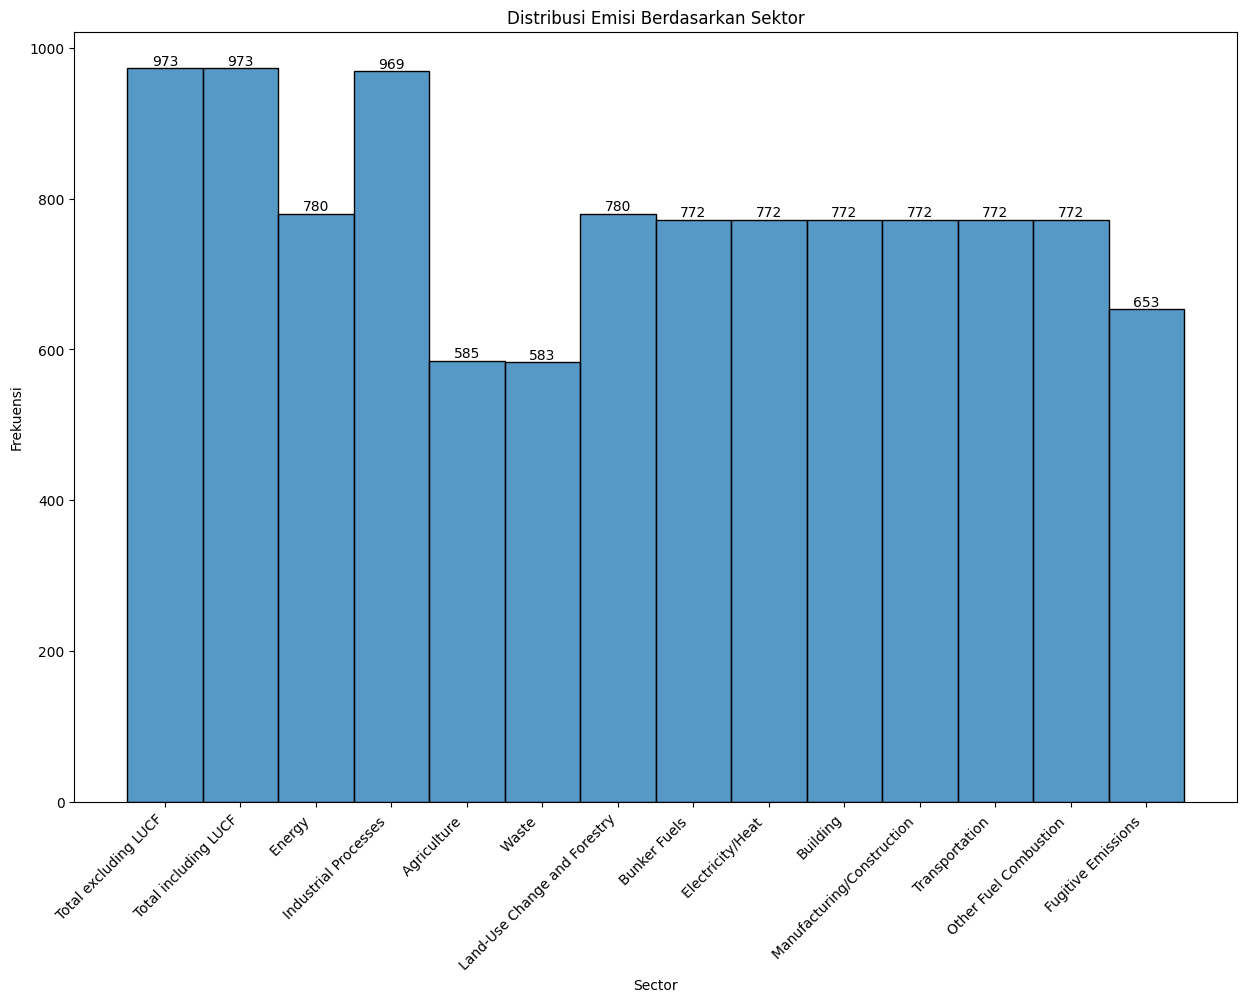

In [5]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Membuat histogram
plt.figure(figsize=(15, 10))
sns.histplot(df['Sector'], kde=False)

# Tambahkan label nilai pada setiap batang histogram
for p in plt.gca().patches:
    # mengiterasi melalui setiap objek batang (patch) dalam plot. 
    # plt.gca() (get current axis) mengambil sumbu x dan y saat ini (current axis) dari plot.
    # anotate guna menambah teks anotasi ke dalam plot
    # {int(p.get_height())} adalah nilai text yang akan ditampilkan sesuai tinggi batang
    plt.gca().annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)
    # p.get_height() mengambil tinggi (nilai y) dari setiap batang dan mengonversi ke integer
    # p.get_x() mengambil posisi x tengah dari setiap batang
    # p.get_width() / 2 mengambil lebar batang dibagi 2 untuk menggesernya ke tengah batang. 
    # p.get_height() mengambil tinggi batang sebagai posisi y
    # set pengaturan secara horizontal di tengah dan vertikal di bawah
    
plt.title('Distribusi Emisi Berdasarkan Sektor')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

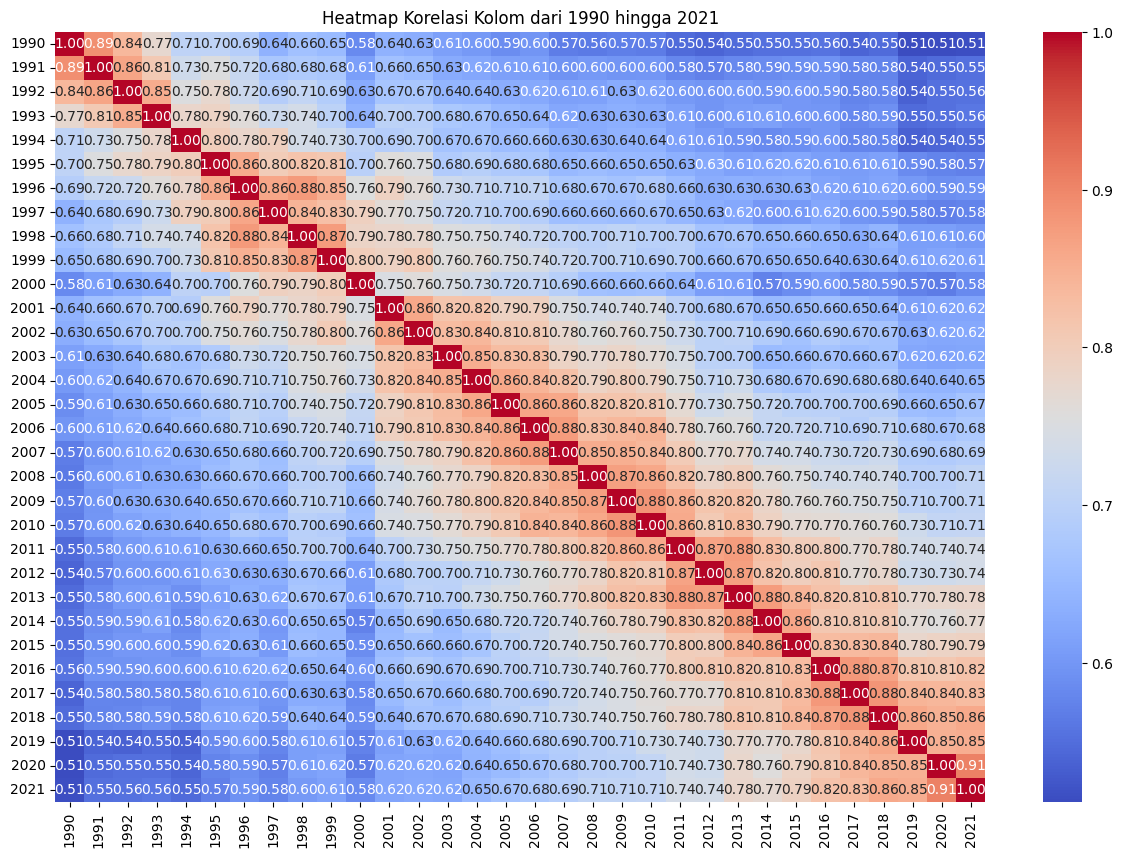

In [6]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Heatmap korelasi
# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Pilih kolom dari 1990 hingga 2021
selected_columns = df_copy[[str(year) for year in range(1990, 2022)]]

plt.figure(figsize=(15, 10))
# Menampilkan heatmap dengan menghitung korelasi pada setiap kolom
# annot=True: Menampilkan nilai korelasi di dalam sel heatmap.
# cmap='coolwarm': Memilih skema warna untuk heatmap (dalam hal ini, dari biru ke merah).
# fmt=".2f": Mengatur format angka untuk nilai korelasi (dalam hal ini, dua desimal).
sns.heatmap(selected_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Kolom dari 1990 hingga 2021')
plt.show()

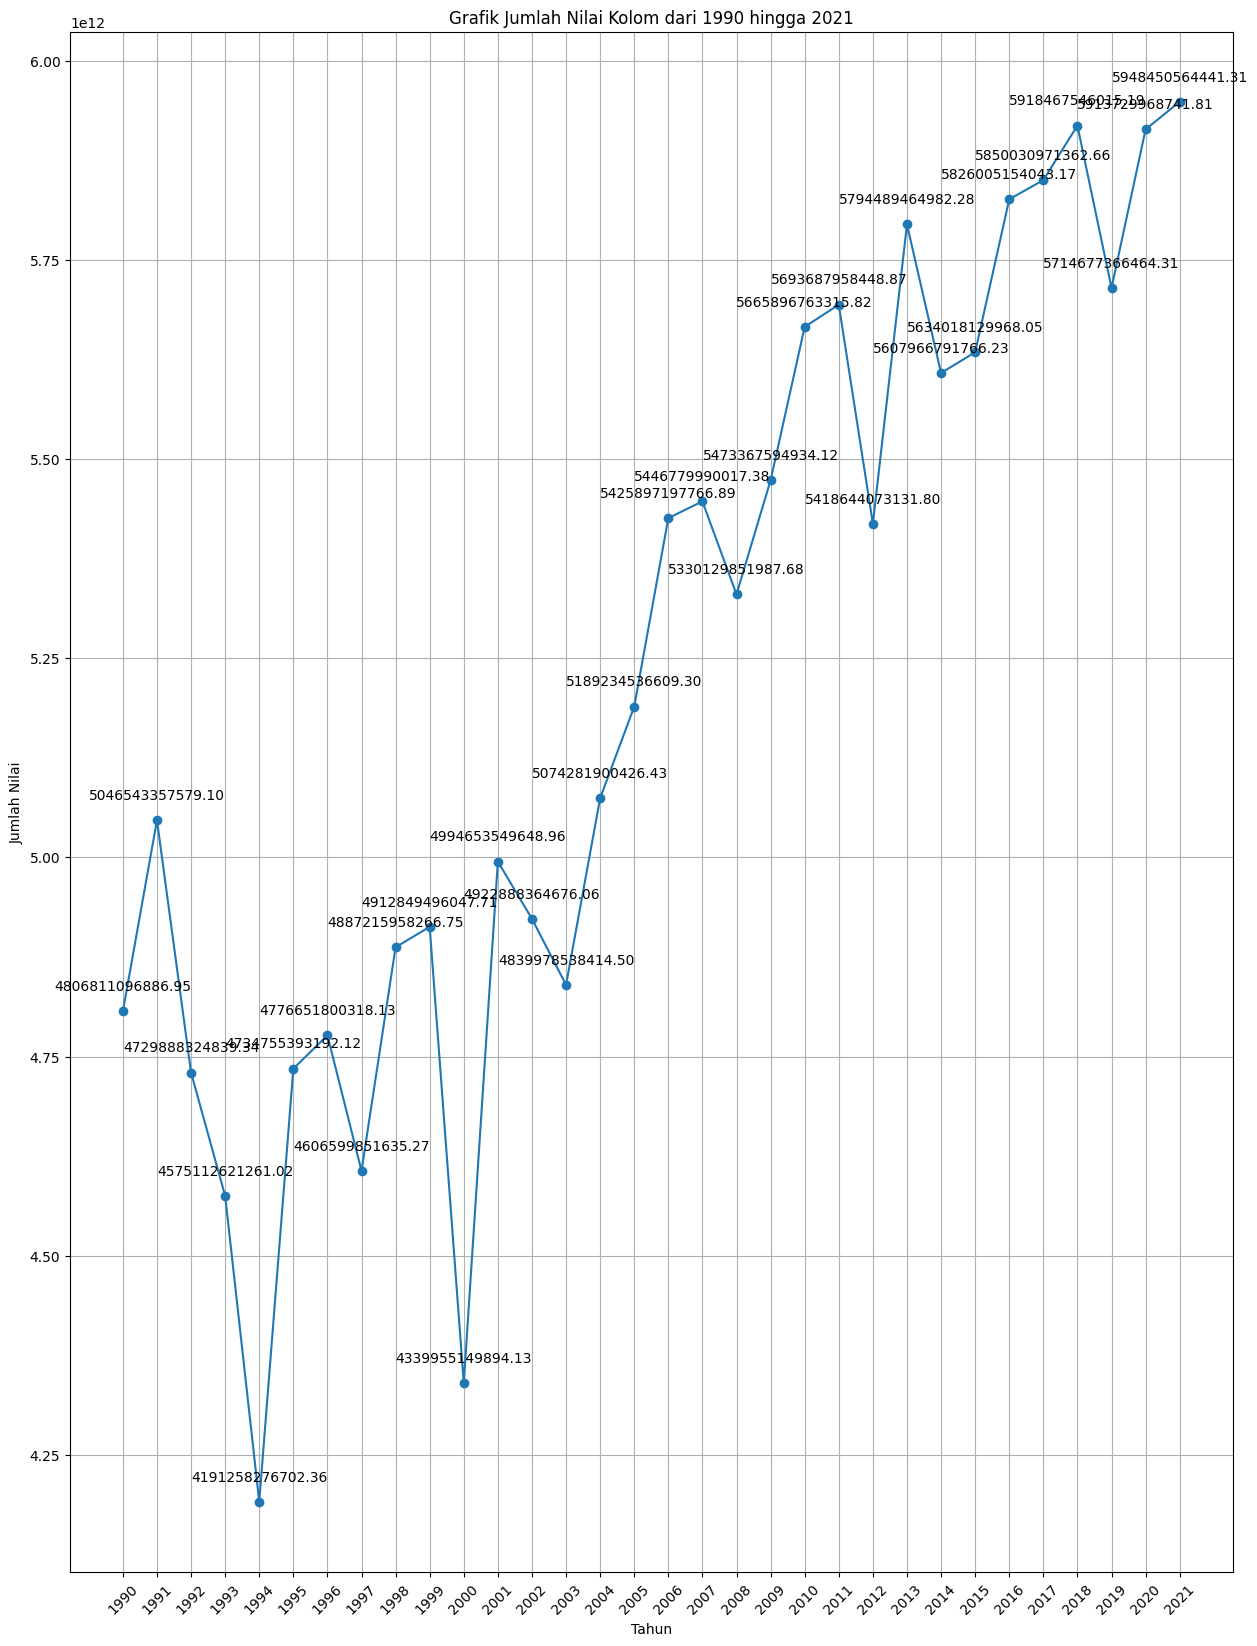

In [7]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Membuat Line Chart
# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Pilih kolom dari 1990 hingga 2021
selected_columns = df_copy[[str(year) for year in range(1990, 2022)]]

# Hitung jumlah nilai untuk setiap tahun
sum_values = selected_columns.sum()
# Atur tampilan angka dengan format desimal penuh
# pd.options.display.float_format = '{:,.2f}'.format

# print(sum_values)
# Buat line chart
plt.figure(figsize=(15, 20))
# Gunakan sum_values.index untuk memilih kolom-kolom dengan nama tahun sebagai index
# Setiap hasil sum dari selected_columns akan disimpan dengan indexnya selected_columns
plt.plot(sum_values.index, sum_values.values, marker='o')

# Tambahkan label pada sumbu x dan y
plt.xlabel('Tahun')
plt.ylabel('Jumlah Nilai')
plt.title('Grafik Jumlah Nilai Kolom dari 1990 hingga 2021')
plt.xticks(rotation=45)  # Memutar label x-axis jika diperlukan
plt.grid(True)

# Tambahkan label nilai untuk setiap titik
# iterasi melalui nilai-nilai dalam sum_values
# enumerate mengembalikan pasangan indeks dan nilai dari sum_values.values
for i, value in enumerate(sum_values.values):
    # Tambah label pada grafik dengan plt.annotate
    # gunakan values sebagai label dan di convert ke string
    # gunakan sum_values.index[i],value sebagai koordinat x dan y text diletakkan
    # textcoords="offset points" menunjukkan bahwa koordinat teks akan diberikan sebagai offset terhadap titik yang ditentukan.
    # xytext=(0, 15) menentukan offset teks dari titik (0 piksel horizontal, 15 piksel vertikal).
    # ha=center mengatur teks agar berpusat pada titik yang ditentukan.
    x_coord = sum_values.index[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (i, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

plt.show()

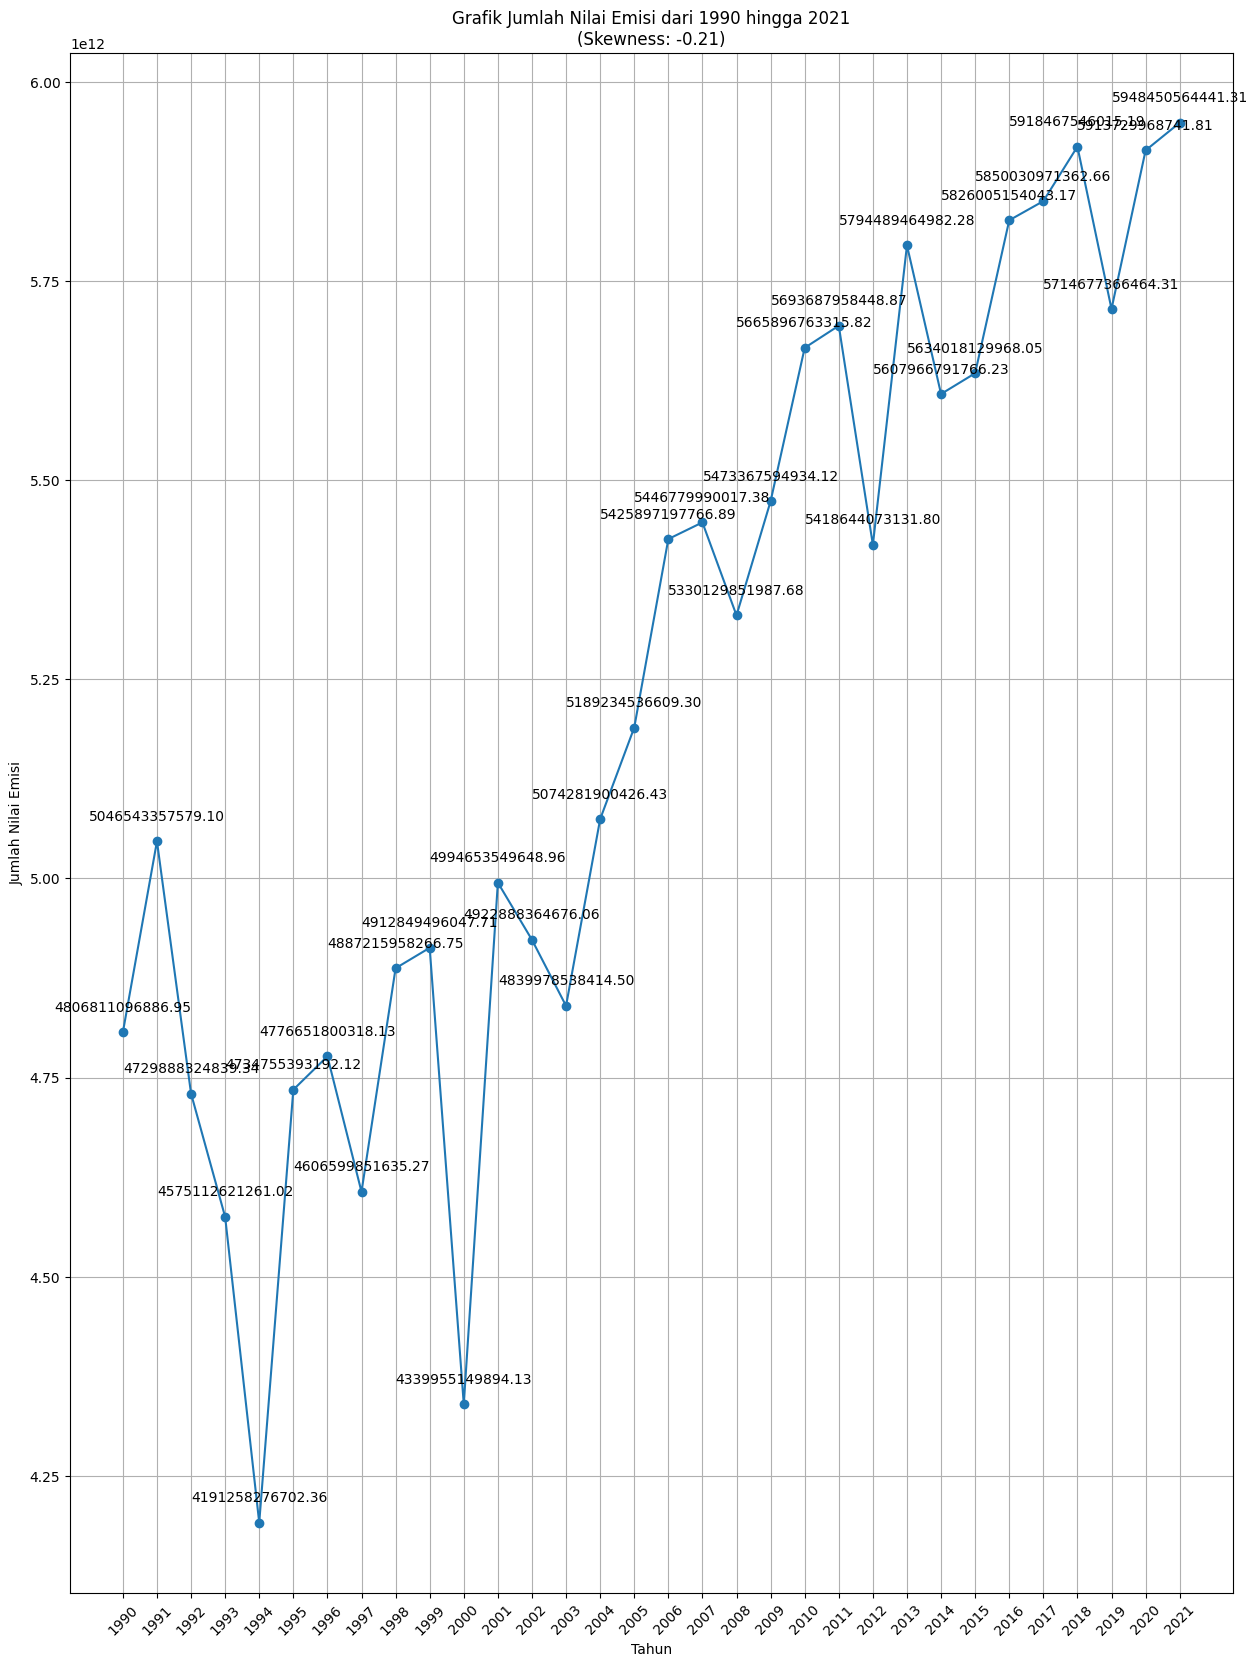

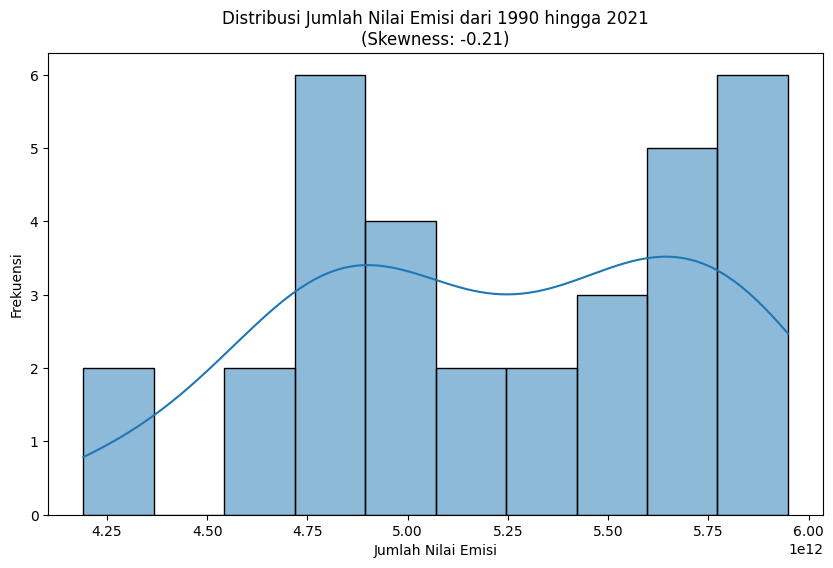

Nilai skewness: -0.21


In [7]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Asumsikan df sudah disediakan, buat salinan dan konversi ke float
df_copy = copy_and_convert_to_float(df)

# Pilih kolom dari 1990 hingga 2021
selected_columns = df_copy[[str(year) for year in range(1990, 2022)]]

# Hitung jumlah nilai untuk setiap tahun
sum_values = selected_columns.sum()

# Hitung skewness dari data
skewness_value = skew(sum_values)

# Plot line chart
plt.figure(figsize=(15, 20))
plt.plot(sum_values.index, sum_values.values, marker='o')

# Tambahkan label pada sumbu x dan y
plt.xlabel('Tahun')
plt.ylabel('Jumlah Nilai Emisi')
plt.title('Grafik Jumlah Nilai Emisi dari 1990 hingga 2021\n(Skewness: {:.2f})'.format(skewness_value))
plt.xticks(rotation=45)  # Memutar label x-axis jika diperlukan
plt.grid(True)

# Tambahkan label nilai untuk setiap titik
for i, value in enumerate(sum_values.values):
    plt.annotate(f'{value:.2f}', (i, value), textcoords="offset points", xytext=(0, 15), ha='center')

# Tampilkan grafik line chart
plt.show()

# Membuat histogram untuk memvisualisasikan distribusi data
plt.figure(figsize=(10, 6))
sns.histplot(sum_values, bins=10, kde=True)

# Tambahkan label pada sumbu x dan y
plt.xlabel('Jumlah Nilai Emisi')
plt.ylabel('Frekuensi')
plt.title('Distribusi Jumlah Nilai Emisi dari 1990 hingga 2021\n(Skewness: {:.2f})'.format(skewness_value))

# Tampilkan histogram
plt.show()

# Tampilkan nilai skewness
print("Nilai skewness: {:.2f}".format(skewness_value))

In [8]:
# import pandas as pd
# import decimal
# from decimal import Decimal

# # Contoh data dengan angka floating point
# data = {
#     '1990': [4806811096886.86, 1234567890123.45, 6789012345678.91],
#     '1991': [3456789012345.67, 2345678901234.56, 7890123456789.01]
# }

# # Membuat DataFrame
# df = pd.DataFrame(data)

# # Menyalin dan mengonversi ke float
# df_copy = df.astype(float)

# # Memeriksa data sebelum dan setelah konversi
# print("Dataframe sebelum konversi:")
# print(df['1990'])
# print("Dataframe setelah konversi:")
# print(df_copy['1990'])

# # Menghitung jumlah nilai untuk setiap tahun dengan float
# sum_values_float = df_copy.sum()

# # Atur tampilan angka dengan format desimal penuh
# pd.options.display.float_format = '{:,.2f}'.format

# print("Jumlah nilai dengan float:")
# print(sum_values_float)

# # Mengatur presisi tinggi
# decimal.getcontext().prec = 30

# # Mengonversi DataFrame ke Decimal
# df_decimal = df.applymap(Decimal)

# # Menghitung jumlah nilai dengan Decimal
# sum_values_decimal = df_decimal.sum()

# print("Jumlah nilai dengan Decimal:")
# print(sum_values_decimal)


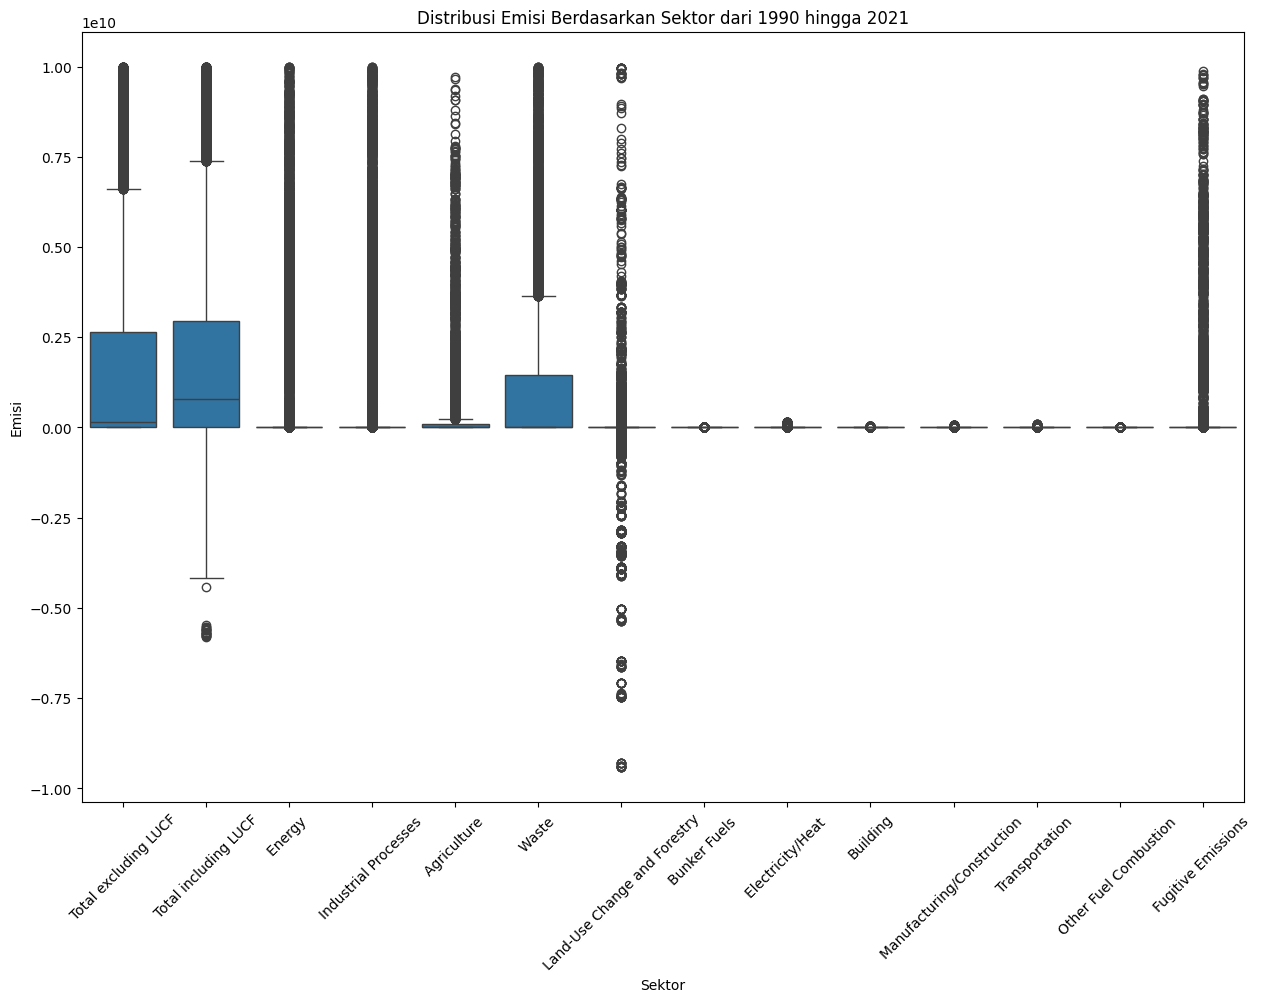

In [9]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Membuat boxplot

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Gabung data dari semua tahun menjadi satu kolom (yang awalnya 1990-2021 tampil secara horizontal jadi Vertikal;)
# Sector sebagai identifier variables
df_melted = df_copy.melt(id_vars=['Sector'], value_vars=[str(year) for year in range(1990, 2022)],
                    var_name='Year', value_name='Emisi')
# df_melted berada dalam format panjang, dengan setiap baris mewakili kombinasi Sector, Year, dan nilai Emisi.

plt.figure(figsize=(15, 10))
sns.boxplot(x='Sector', y='Emisi', data=df_melted)
plt.title('Distribusi Emisi Berdasarkan Sektor dari 1990 hingga 2021')
plt.xlabel('Sektor')
plt.ylabel('Emisi')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Mengubah data dari format wide menjadi long untuk memudahkan analisis
df_long = df_copy.melt(id_vars=['Country_Name', 'Country', 'Source', 'Sector', 'Gas'],
                  var_name='Year', value_name='Emissions')

# Mengubah tahun menjadi numerik
df_long['Year'] = df_long['Year'].astype(int)

# Memastikan semua nilai dalam kolom 'Emissions' adalah string
df_long['Emissions'] = df_long['Emissions'].astype(float)

# Mengisi nilai NaN dengan 0 (jika ada)
df_long['Emissions'] = df_long['Emissions'].fillna(0)

# Encoding kategorikal data
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_long[['Sector']])

# Menambahkan hasil encoding ke dataframe
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Sector']))
df_long_encoded = pd.concat([df_long.reset_index(drop=True), encoded_df], axis=1)

# Menghilangkan kolom yang tidak diperlukan untuk regresi
df_long_encoded.drop(columns=['Country_Name', 'Country', 'Source', 'Sector', 'Gas'], inplace=True)

# Membagi dataset menjadi fitur dan target
X = df_long_encoded.drop(columns=['Emissions'])
y = df_long_encoded['Emissions']

# Menyiapkan data untuk VIF
X_vif = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Sector']))
X_vif['Year'] = df_long['Year']

# Menghitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("VIF Data:")
print(vif_data)

# Menyimpan nama kolom sebelum normalisasi
feature_names = X.columns

# Normalisasi fitur
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Melakukan regresi linear
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Memprediksi hasil pada testing set
y_pred = regressor.predict(X_test)

# Menilai hasil regresi
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Menampilkan koefisien regresi
coefficients = pd.DataFrame(regressor.coef_, feature_names, columns=['Coefficient'])
print("Koefisien Regresi Linear:")
print(coefficients)

# Menggunakan Lasso untuk seleksi fitur
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

# Menilai hasil regresi dengan Lasso
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Mean Squared Error: {mse_lasso}")
print(f"Lasso R^2 Score: {r2_lasso}")

# Menampilkan koefisien Lasso
coefficients_lasso = pd.DataFrame(lasso.coef_, feature_names, columns=['Coefficient'])
print("Koefisien Regresi Lasso:")
print(coefficients_lasso)

VIF Data:
                                feature          VIF
0                   Sector_Agriculture   2526.377955
1                       Sector_Building  3333.635524
2                  Sector_Bunker Fuels   3333.635524
3              Sector_Electricity/Heat   3333.635524
4                        Sector_Energy   3368.170607
5            Sector_Fugitive Emissions   2819.926162
6          Sector_Industrial Processes   4184.061947
7   Sector_Land-Use Change and Forestry  3368.170607
8    Sector_Manufacturing/Construction   3333.635524
9         Sector_Other Fuel Combustion   3333.635524
10          Sector_Total excluding LUCF  4201.329488
11          Sector_Total including LUCF  4201.329488
12               Sector_Transportation   3333.635524
13                        Sector_Waste   2517.744185
14                           Sector_nan     5.316885
15                                 Year     1.000000
Mean Squared Error: 1.76791214639866e+18
R^2 Score: 0.2049960704805357
Koefisien Regresi 

Augmented Dickey-Fuller Test: Original Data
ADF Statistic                  -0.106749
p-value                         0.948762
#Lags Used                      2.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64

Augmented Dickey-Fuller Test: Differencing 1
ADF Statistic                 -6.458194e+00
p-value                        1.465445e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.900000e+01
Critical Value (1%)           -3.679060e+00
Critical Value (5%)           -2.967882e+00
Critical Value (10%)          -2.623158e+00
dtype: float64



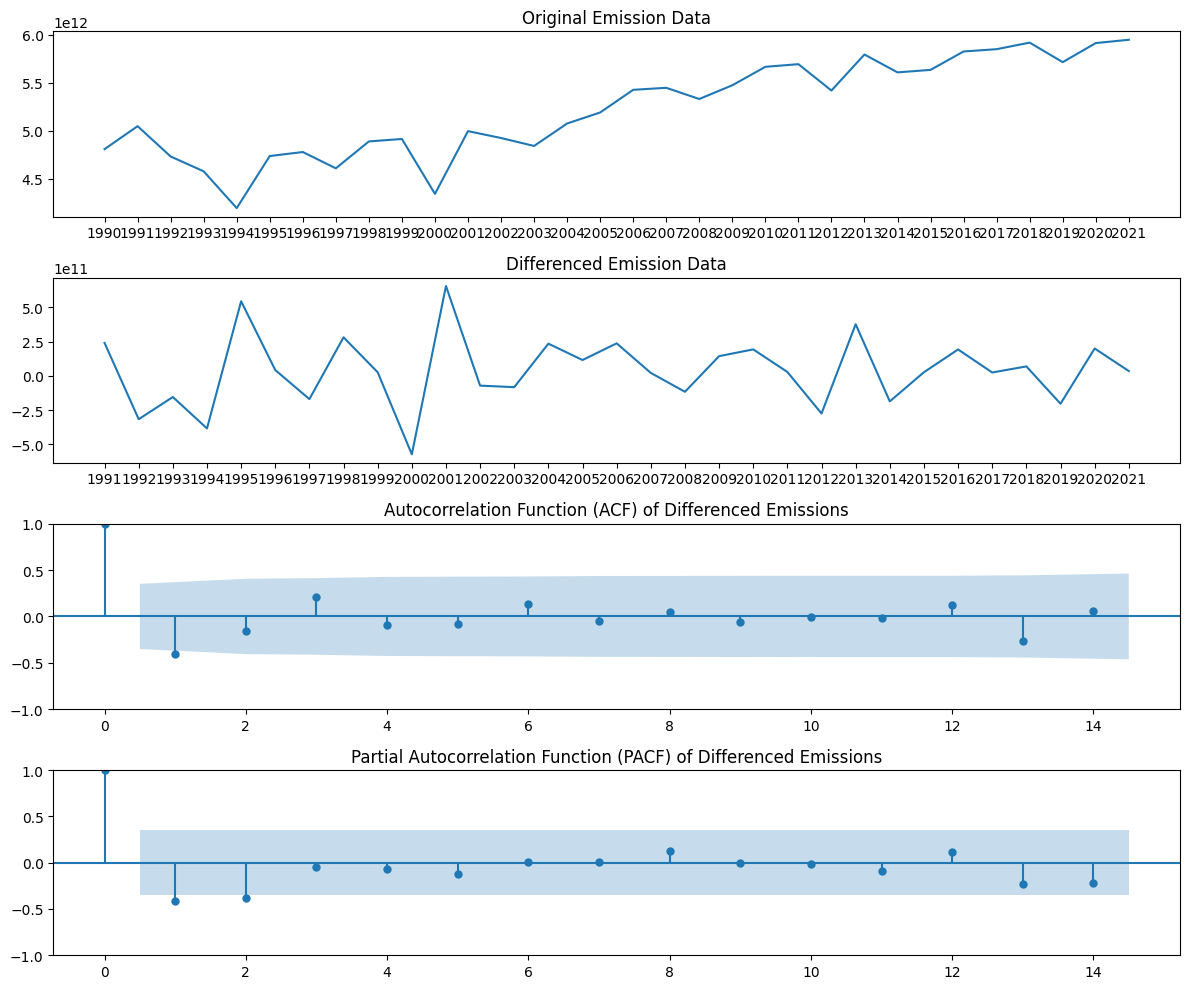

In [11]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)
    
# Mengambil data emisi dari tahun 1990 hingga 2021
emission_data = df_copy.loc[:, '1990':'2021']

# Menjumlahkan data emisi dari semua negara untuk setiap tahun
emission_data_sum = emission_data.sum(axis=0)

# Fungsi untuk melakukan uji Dickey-Fuller dan mencetak hasilnya
def adfuller_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# Lakukan differencing hingga data stasioner
differenced_data = emission_data_sum
adfuller_test(differenced_data, 'Original Data')
differenced_count=0
# Lakukan differencing selanjutnya jika perlu
if adfuller(differenced_data)[1] >= 0.05:
    while adfuller(differenced_data)[1] >= 0.05:
        differenced_data = differenced_data.diff().dropna()
        differenced_count+=1
        adfuller_test(differenced_data, 'Differencing '+ str(differenced_count))
    
# Plot data asli
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(emission_data_sum)
plt.title('Original Emission Data')

# Plot differencing data
plt.subplot(4, 1, 2)
plt.plot(differenced_data)
plt.title('Differenced Emission Data')

# Plot ACF dari data yang sudah di-differencing
plt.subplot(4, 1, 3)
plot_acf(differenced_data, ax=plt.gca(), lags=14)
plt.title('Autocorrelation Function (ACF) of Differenced Emissions')

# Plot PACF dari data yang sudah di-differencing
plt.subplot(4, 1, 4)
plot_pacf(differenced_data, ax=plt.gca(), lags=14)
plt.title('Partial Autocorrelation Function (PACF) of Differenced Emissions')

plt.tight_layout()
plt.show()

In [12]:
# # Debugging preprocessing steps
# print("Preprocessing output for first code:")
# print(emission_data_sum.describe())

# # Debugging stationarity transformation
# print("Stationarity transformation output for first code:")
# print(differenced_data.describe())

Preprocessing output for first code:
count    3.200000e+01
mean     5.227841e+12
std      5.016156e+11
min      4.191258e+12
25%      4.831687e+12
50%      5.259682e+12
75%      5.672845e+12
max      5.948451e+12
dtype: float64
Stationarity transformation output for first code:
count    3.100000e+01
mean     3.682708e+10
std      2.604293e+11
min     -5.728943e+11
25%     -1.357129e+11
50%      2.779120e+10
75%      1.957909e+11
max      6.546984e+11
dtype: float64


In [22]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Cleaning data untuk diproses
# Fungsi preprocess data
def preprocess_data(df):
    df_copy = df.copy()
    # print("Data awal:")
    # print(df_copy.head())
    
    df_copy = df_copy.groupby('Country').sum().loc[:, '1990':'2021']
    # print("Setelah memilih kolom tahun:")
    # print(df_copy.head())
    
    # Convert to float if not already
    if df_copy.dtypes.any() == 'object':
        df_copy = df_copy.apply(lambda col: col.map(lambda x: float(str(x).replace('.', '').replace(',', '.'))))
    
    # print("Setelah konversi ke float:")
    # print(df_copy.head())
    
    df_copy = df_copy.sum(axis=0).reset_index()
    # print("Setelah sum dan reset index:")
    # print(df_copy.head())
    
    df_copy.columns = ['Year', 'Emission']
    # print("Setelah mengganti nama kolom:")
    # print(df_copy.head())
    
    # Konversi kolom 'Year' menjadi integer
    df_copy['Year'] = df_copy['Year'].astype(float)
    # print("Setelah konversi ke datetime dan set index:")
    # print(df_copy.head())
    
    return df_copy


# Function to preprocess data and remove outliers
def preprocess_data_with_remove_outliers(df):
    df_copy = preprocess_data(df)
    
    # Debugging: Calculate and display Q1, Q3, and IQR
    Q1 = df_copy['Emission'].quantile(0.25)
    Q3 = df_copy['Emission'].quantile(0.75)
    IQR = Q3 - Q1
    
    # print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    
    # Debugging: Display count of rows before removing outliers
    # print(f"Number of rows before removing outliers: {df_copy.shape[0]}")
    
    df_copy = df_copy[(df_copy['Emission'] >= Q1 - 1.5 * IQR) & (df_copy['Emission'] <= Q3 + 1.5 * IQR)]
    
    # Debugging: Display count of rows after removing outliers
    # print(f"Number of rows after removing outliers: {df_copy.shape[0]}")
    
    return df_copy

def make_stationary(df, log_transform=False, seasonal_lag=None):
    warnings.resetwarnings()
    warnings.simplefilter("ignore")
    df_copy = df.copy()
    original_emission = df_copy['Emission'].copy()  # Copy original Emission for debugging

    # Opsi transformasi logaritmik
    if log_transform:
        df_copy['Emission_diff'] = np.log(df_copy['Emission'])
    else:
        df_copy['Emission_diff']=df_copy['Emission']
    
    # print("Initial Emission Values:\n", original_emission.head())
        
    # Perform ADF test
    adf_test_result = adfuller(df_copy['Emission_diff'].dropna())
    differencing_count = 0
    
    kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')

    # If the data is not stationary, perform differencing
    if adf_test_result[1] >= 0.05 or kpss_test_result[1]<0.05:
        df_copy['Emission_diff'] = df_copy['Emission_diff'].diff()
        df_copy['Emission_diff'] = df_copy['Emission_diff'].dropna()
        differencing_count += 1
        # print(f"Emission after first differencing (count: {differencing_count}):\n", df_copy['Emission'].head())
        # print(f"Emission_diff after first differencing (count: {differencing_count}):\n", df_copy['Emission_diff'].head())
        
        # Perform ADF test on the differenced data
        adf_test_result = adfuller(df_copy['Emission_diff'].dropna())
        kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
        
        # Continue differencing until the data is stationary
        while adf_test_result[1] >= 0.05 or kpss_test_result[1] < 0.05:
            df_copy['Emission_diff'] = df_copy['Emission_diff'].diff().dropna()
            adf_test_result = adfuller(df_copy['Emission_diff'].dropna())
            differencing_count += 1
            
            # print(f"Emission after differencing (count: {differencing_count}):\n", df_copy['Emission'].head())
            # print(f"Emission_diff after differencing (count: {differencing_count}):\n", df_copy['Emission_diff'].head())
    
    # Drop rows with NaN values resulting from differencing
    df_copy['Emission_diff'] = df_copy['Emission_diff'].dropna()
    
    # Debugging: Check if original Emission column has changed
    # print("Final Emission Values:\n", df_copy['Emission'].head())
    assert original_emission.equals(df_copy['Emission']), "Column 'Emission' has been modified!"

    # Print jumlah differencing yang dilakukan dan nilai p-value
    # print(f"Differencing count: {differencing_count}")
    # print(f"ADF p-value: { adf_test_result[1]}, KPSS p-value: {kpss_test_result[1]}")

    # Return the dataframe with 'Year', 'Emission', and 'Emission_diff'
    return df_copy[['Year', 'Emission', 'Emission_diff']]

def normalize_data(df, mean=None, std=None):
    df_copy = df.copy()
    if mean is None and std is None:
        mean = df_copy['Emission'].mean()
        std = df_copy['Emission'].std()
    df_copy['Emission'] = (df_copy['Emission'] - mean) / std
    return df_copy, mean, std

def denormalize_data(data, mean, std):
    return data * std + mean

def normalize_data_diff(df, mean=None, std=None):
    df_copy = df.copy()
    if mean is None and std is None:
        mean = df_copy['Emission_diff'].mean()
        std = df_copy['Emission_diff'].std()
    df_copy['Emission_diff'] = (df_copy['Emission_diff'] - mean) / std
    return df_copy, mean, std

Augmented Dickey-Fuller Test: Original Data
ADF Statistic                  -0.106749
p-value                         0.948762
#Lags Used                      2.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64

Augmented Dickey-Fuller Test: Differencing 1
ADF Statistic                 -6.458194e+00
p-value                        1.465445e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.900000e+01
Critical Value (1%)           -3.679060e+00
Critical Value (5%)           -2.967882e+00
Critical Value (10%)          -2.623158e+00
dtype: float64



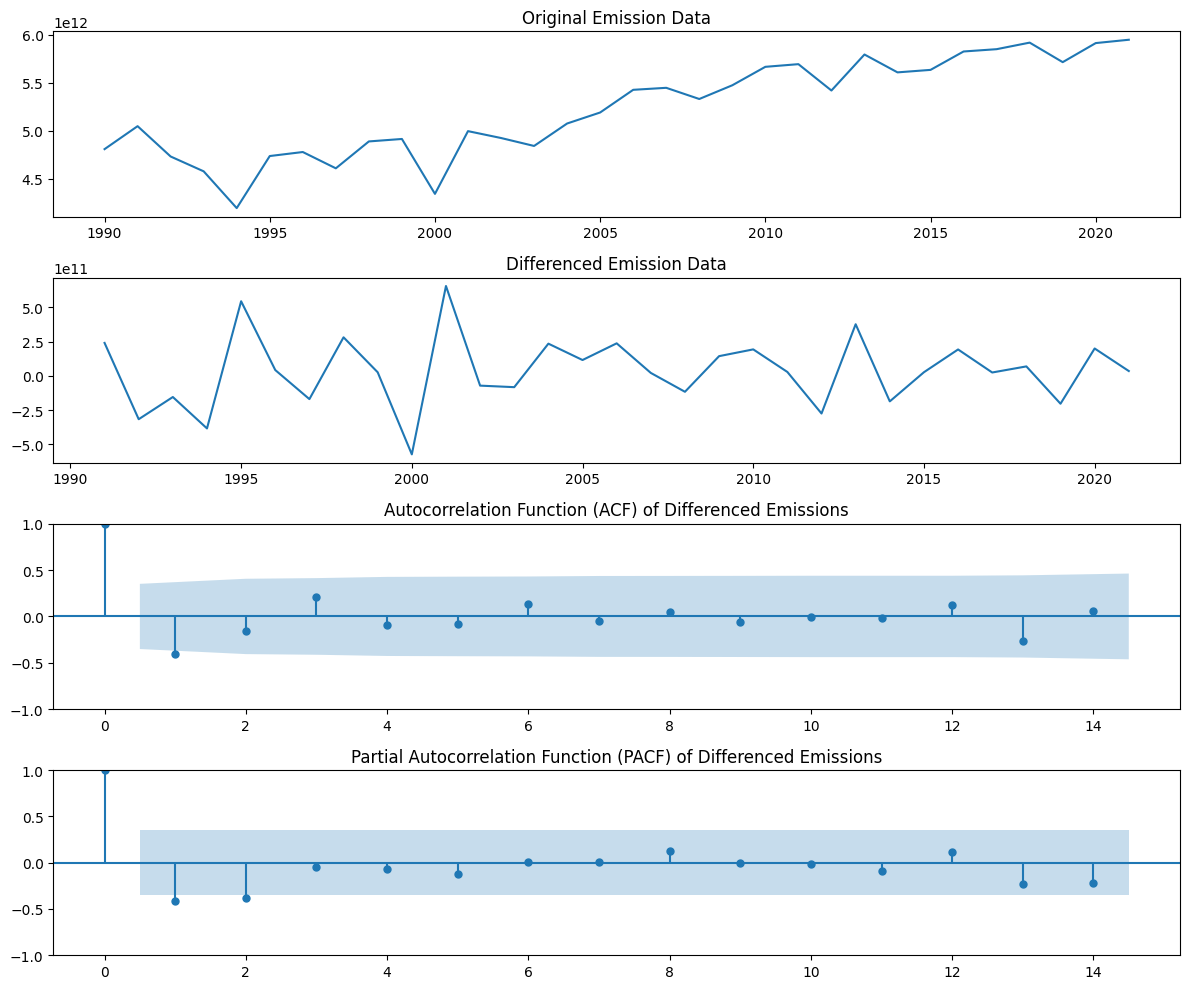

In [14]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Preprocess data
df_preprocessed = preprocess_data(df_copy)

# Menjumlahkan data emisi dari semua negara untuk setiap tahun
emission_data_sum = df_preprocessed.set_index('Year')['Emission']

# Fungsi untuk melakukan uji Dickey-Fuller dan mencetak hasilnya
def adfuller_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# Lakukan differencing hingga data stasioner
differenced_data = emission_data_sum
adfuller_test(differenced_data, 'Original Data')
differenced_count = 0

# Lakukan differencing selanjutnya jika perlu
if adfuller(differenced_data)[1] >= 0.05:
    while adfuller(differenced_data)[1] >= 0.05:
        differenced_data = differenced_data.diff().dropna()
        differenced_count += 1
        adfuller_test(differenced_data, 'Differencing ' + str(differenced_count))

# Plot data asli
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(emission_data_sum)
plt.title('Original Emission Data')

# Plot differencing data
plt.subplot(4, 1, 2)
plt.plot(differenced_data)
plt.title('Differenced Emission Data')

# Plot ACF dari data yang sudah di-differencing
plt.subplot(4, 1, 3)
plot_acf(differenced_data, ax=plt.gca(), lags=14)
plt.title('Autocorrelation Function (ACF) of Differenced Emissions')

# Plot PACF dari data yang sudah di-differencing
plt.subplot(4, 1, 4)
plot_pacf(differenced_data, ax=plt.gca(), lags=14)
plt.title('Partial Autocorrelation Function (PACF) of Differenced Emissions')

plt.tight_layout()
plt.show()

In [9]:
# import statsmodels
# print(statsmodels.__version__)

0.14.2


In [8]:
# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

print("Data asli:")
print(df_copy.describe())

# Debugging preprocessing steps
print("Preprocessing output:")
df_copy_1 = preprocess_data(df_copy)
print(df_copy_1.describe())

print("Preprocessing output with remove outlier:")
df_copy_1 = preprocess_data_with_remove_outliers(df_copy)
print(df_copy_1.describe())

# Debugging stationarity transformation
print("Stationarity transformation:")
df_stationary_1 = make_stationary(df_copy_1)
print(df_stationary_1.describe())

# Debugging stationarity transformation
print("Stationarity transformation with log:")
df_stationary_1 = make_stationary(df_copy_1, log_transform=True)
print(df_stationary_1.describe())

# Debugging train-test split
train_size_1 = int(len(df_stationary_1) * 0.8)
train_1, test_1 = df_stationary_1.iloc[:train_size_1], df_stationary_1.iloc[train_size_1:]
print("Train-Test split output for first code:")
print(train_1.describe())
print(test_1.describe())

# Calculate avg_actual for both test sets
avg_actual_1 = np.mean(test_1['Emission_diff'])
print(f"avg_actual for first set of code: {avg_actual_1}")

# Debugging stationarity transformation
print("Stationarity transformation with log:")
df_stationary_1 = make_stationary(df_copy_1, log_transform=True)
print(df_stationary_1.describe())

Data asli:
               1990          1991          1992          1993          1994  \
count  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04   
mean   4.398619e+08  4.617994e+08  4.328229e+08  4.186596e+08  3.835339e+08   
std    1.456586e+09  1.502257e+09  1.443910e+09  1.398851e+09  1.321385e+09   
min   -9.399078e+09 -9.399078e+09 -9.399078e+09 -5.815244e+09 -5.791219e+09   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.600000e-01  1.700000e-01  1.800000e-01  1.800000e-01  1.800000e-01   
75%    1.762282e+05  1.954585e+05  1.927780e+05  1.887858e+05  1.764272e+05   
max    9.993854e+09  9.994997e+09  9.980806e+09  9.995412e+09  9.994665e+09   

               1995          1996          1997          1998          1999  \
count  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04   
mean   4.332682e+08  4.371021e+08  4.215410e+08  4.472196e+08  4.495653e+08   
std    1.418977e+09  1.427237e+09  1.406

C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:76: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:76: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:88: 

In [12]:
# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

print("Data asli:")
print(df_copy.describe())

# Debugging preprocessing steps
print("Preprocessing output:")
df_copy_1 = preprocess_data(df_copy)
print(df_copy_1.describe())

print("Preprocessing output with remove outlier:")
df_copy_1 = preprocess_data_with_remove_outliers(df_copy)
print(df_copy_1.describe())

# Debugging stationarity transformation
print("Stationarity transformation:")
df_stationary_1 = make_stationary(df_copy_1)
print(df_stationary_1.describe())

# Debugging train-test split
train_size_1 = int(len(df_stationary_1) * 0.8)
train_1, test_1 = df_stationary_1.iloc[:train_size_1], df_stationary_1.iloc[train_size_1:]
print("Train-Test split output for first code:")
print(train_1.describe())
print(test_1.describe())

# Calculate avg_actual for both test sets
avg_actual_1 = np.mean(test_1['Emission_diff'])
print(f"avg_actual for first set of code: {avg_actual_1}")

Data asli:
               1990          1991          1992          1993          1994  \
count  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04   
mean   4.398619e+08  4.617994e+08  4.328229e+08  4.186596e+08  3.835339e+08   
std    1.456586e+09  1.502257e+09  1.443910e+09  1.398851e+09  1.321385e+09   
min   -9.399078e+09 -9.399078e+09 -9.399078e+09 -5.815244e+09 -5.791219e+09   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.600000e-01  1.700000e-01  1.800000e-01  1.800000e-01  1.800000e-01   
75%    1.762282e+05  1.954585e+05  1.927780e+05  1.887858e+05  1.764272e+05   
max    9.993854e+09  9.994997e+09  9.980806e+09  9.995412e+09  9.994665e+09   

               1995          1996          1997          1998          1999  \
count  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04  1.092800e+04   
mean   4.332682e+08  4.371021e+08  4.215410e+08  4.472196e+08  4.495653e+08   
std    1.418977e+09  1.427237e+09  1.406

C:\Users\ACER\AppData\Local\Temp\ipykernel_52508\1700572599.py:76: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_52508\1700572599.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


In [15]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction(df, steps=9):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'


    model = ARIMA(df_copy['Emission_diff'], order=(2, 1, 1))
    model_fit = model.fit()

    # Prediksi differencing
    diff_predictions = model_fit.forecast(steps=steps)

    # Ambil nilai emisi terakhir sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[-1]

    # Kembalikan prediksi ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        current_value += diff
        absolute_predictions.append(current_value)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, absolute_predictions

# Contoh penggunaan fungsi
forecast_years, absolute_predictions = emission_prediction(df_copy)
for year, emission in zip(forecast_years, absolute_predictions):
    print(f'Year: {year} with forecasted emission: {emission}')

C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:76: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


Year: 2022 with forecasted emission: 5927813443771.802
Year: 2023 with forecasted emission: 5993655206109.541
Year: 2024 with forecasted emission: 6033344085325.244
Year: 2025 with forecasted emission: 6056597184329.024
Year: 2026 with forecasted emission: 6097623385206.906
Year: 2027 with forecasted emission: 6135040608819.567
Year: 2028 with forecasted emission: 6168151272190.306
Year: 2029 with forecasted emission: 6204786555546.046
Year: 2030 with forecasted emission: 6241071686964.862


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 60973555393.1663
Mean Squared Error (MSE): 6.426583706114705e+21
Root Mean Squared Error (RMSE): 80165975988.03812
MAE Percentage Error: 1.0460
MSE Percentage Error: 110245478102.1441
RMSE Percentage Error: 1.3752
MAPE: 1.0503%
MSPE: 0.0192%
RMSPE: 0.1385%
AIC: 1338.6085
BIC: 1343.3207


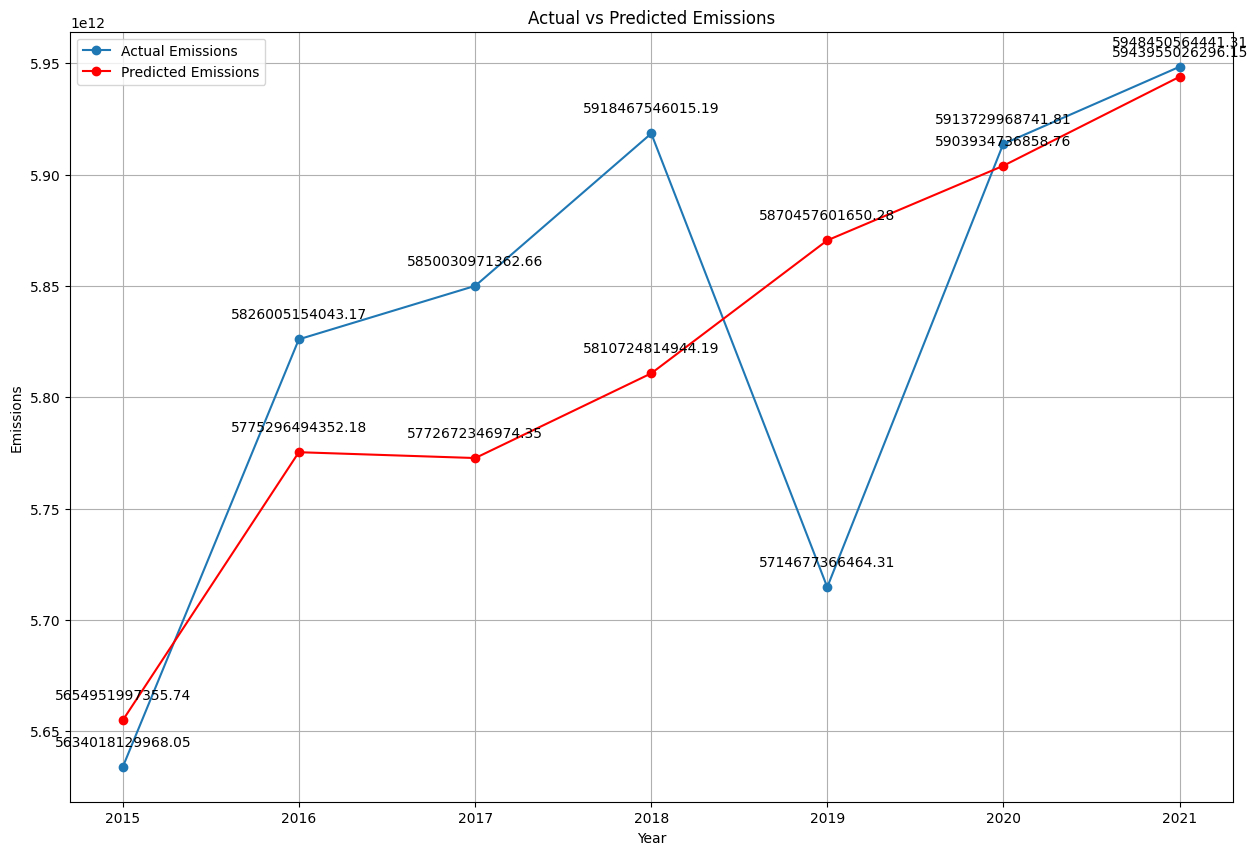

In [24]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_arima_model(df, train_size=0.8, order=(2, 1, 1)):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            model = ARIMA(train['Emission_diff'], order=order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None
    
    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    diff_predictions = model_fit.predict(start=start, end=end)

    # Ambil nilai emisi terakhir dari train set sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[train_size - 1]

    # Konversi prediksi differenced ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        current_value += diff  
        absolute_predictions.append(current_value)

    # Konversi prediksi ke DataFrame
    predictions = pd.Series(absolute_predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return model_fit, avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
model_fit, avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_arima_model(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}')
print(f'MSE Percentage Error: {mse_percentage:.4f}')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:76: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_17392\1700572599.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


diff_predictions: 2015-01-01    4.698521e+10
2016-01-01    1.203445e+11
2017-01-01   -2.624147e+09
2018-01-01    3.805247e+10
2019-01-01    5.973279e+10
2020-01-01    3.347714e+10
2021-01-01    4.002029e+10
Freq: YS-JAN, Name: predicted_mean, dtype: float64
residual NA:
1
Residuals contain NaN values, removing them.
Number of residuals: 24


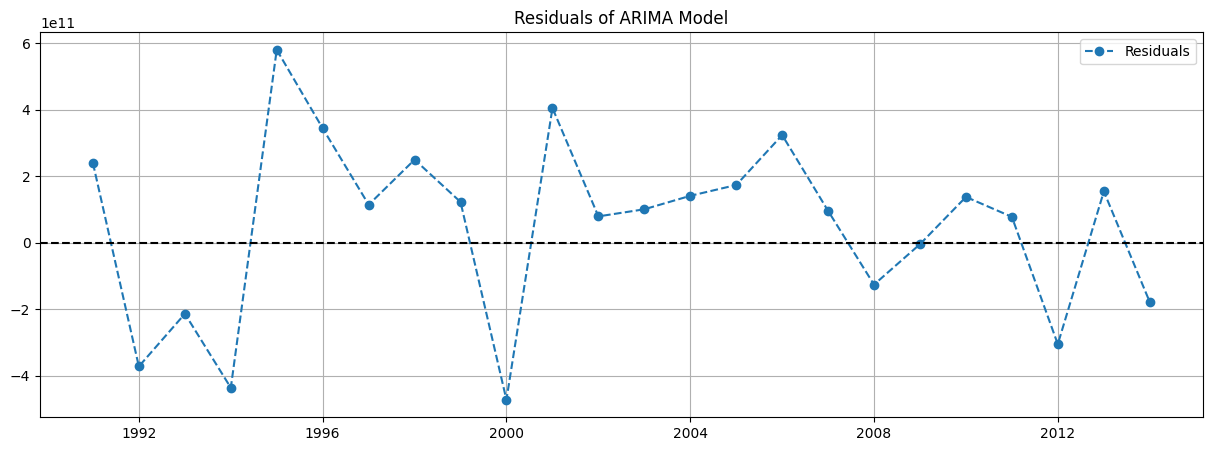

<Figure size 1500x500 with 0 Axes>

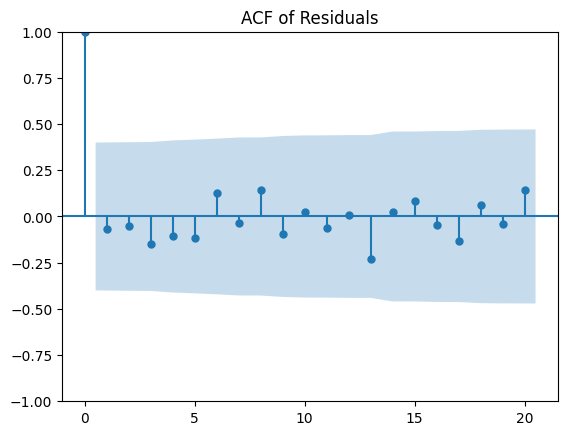

Durbin-Watson statistic: 2.010214206028782
Ljung-Box test results:
     lb_stat  lb_pvalue
10  3.479411   0.967793
Residuals appear to be white noise (p-value > 0.05)
Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 60973555393.1663
Mean Squared Error (MSE): 6.426583706114705e+21
Root Mean Squared Error (RMSE): 80165975988.03812
MAE Percentage Error: 1.0460
MSE Percentage Error: 110245478102.1441
RMSE Percentage Error: 1.3752
MAPE: 1.0503%
MSPE: 0.0192%
RMSPE: 0.1385%
AIC: 1338.6085
BIC: 1343.3207


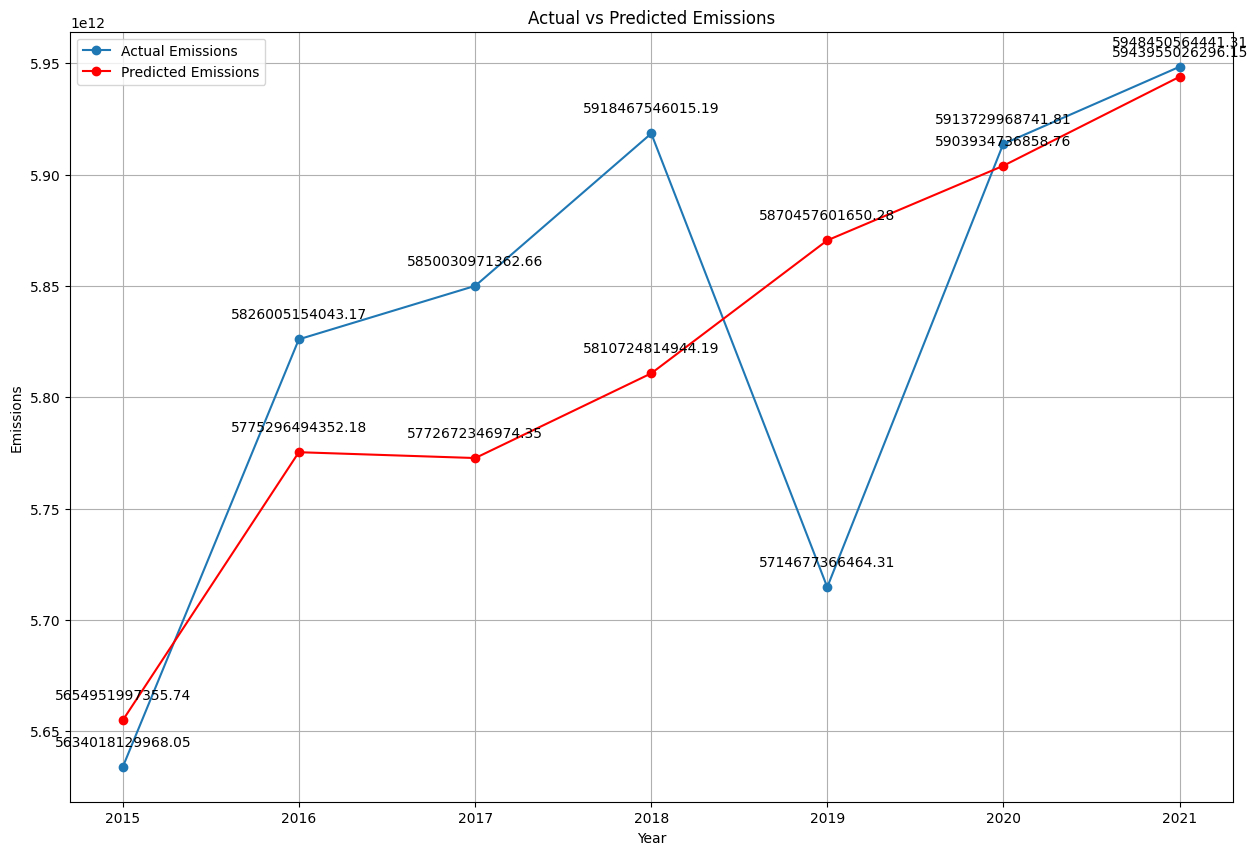

In [20]:
# Membuat evaluasi model ARIMA yang dibuat
def evaluate_arima_model_ljung_box_test(df, train_size=0.8, order=(2, 1, 1)):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            model = ARIMA(train['Emission_diff'], order=order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None
    
    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    diff_predictions = model_fit.predict(start=start, end=end)

    # Debug: Print prediksi absolut sebelum menggunakan expm1
    print(f"diff_predictions: {diff_predictions}")

    # Ambil nilai emisi terakhir dari train set sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[train_size - 1]

    # Konversi prediksi differenced ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        current_value += diff  
        absolute_predictions.append(current_value)
    
    predictions = pd.Series(absolute_predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    # ------------------ Analisis Residuals ------------------
    residuals = model_fit.resid  # Ambil residuals dari model ARIMA
    print("residual NA:")
    print(residuals.isna().sum())
    # Periksa apakah residuals mengandung NaN
    if residuals.isna().sum() > 0:
        print("Residuals contain NaN values, removing them.")
        residuals = residuals.dropna()
    print(f"Number of residuals: {len(residuals)}")
    
    # Plot residuals
    plt.figure(figsize=(15, 5))
    plt.plot(residuals, label='Residuals', marker='o', linestyle='dashed')
    plt.title('Residuals of ARIMA Model')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot ACF of residuals
    plt.figure(figsize=(15, 5))
    plot_acf(residuals, lags=20)
    plt.title('ACF of Residuals')
    plt.show()

    # ------------------ Ljung-Box Test ------------------
    # Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(residuals)
    print(f'Durbin-Watson statistic: {dw_stat}')
    lb_test_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box test results:")
    print(lb_test_results)
    # Interpret Ljung-Box Test
    if lb_test_results['lb_pvalue'].iloc[0] > 0.05:
        print("Residuals appear to be white noise (p-value > 0.05)")
    else:
        print("Residuals show significant autocorrelation (p-value <= 0.05)")
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_arima_model_ljung_box_test(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}')
print(f'MSE Percentage Error: {mse_percentage:.4f}')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Fungsi untuk evaluasi ARIMA model menggunakan cross-validation
def evaluate_arima_model_cv(df, order, train_size=0.8, n_splits=5):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)
    
    # Set 'Year' as index and ensure correct frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensure yearly frequency

    train_size = int(len(df_copy) * train_size)
    train = df_copy[:train_size]

    # Inisialisasi cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_list = []
    
    for train_index, test_index in tscv.split(df_copy):
        train, test = df_copy.iloc[train_index], df_copy.iloc[test_index]
        
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter('always')
                
                # Fit ARIMA model
                model = ARIMA(train['Emission_diff'], order=order)
                model_fit = model.fit()
                
                # Tangani peringatan yang muncul (non-stationary AR atau non-invertible MA)
                for warning in w:
                    if issubclass(warning.category, (UserWarning, ConvergenceWarning)):
                        print(f"Warning for parameters {order}: {warning.message}")
                        return None  # Jika ada warning, abaikan model ini
                
                # Predict test data
                start = len(train)
                end = len(train) + len(test) - 1
                diff_predictions = model_fit.predict(start=start, end=end)
                
                # Konversi differenced predictions ke nilai absolut
                last_actual_value = train['Emission'].iloc[-1]
                absolute_predictions = [last_actual_value + diff for diff in diff_predictions]
                
                # Hitung RMSE
                rmse = np.sqrt(mean_squared_error(test['Emission'], absolute_predictions))
                rmse_list.append(rmse)
        
        except (ValueError, np.linalg.LinAlgError) as e:
            print(f"Error for parameters {order}: {e}")
            return None
    
    # Mengembalikan rata-rata RMSE jika tidak ada warning atau error
    if rmse_list:
        avg_rmse = np.mean(rmse_list)
        return avg_rmse
    else:
        return None

# Fungsi untuk grid search dengan cross-validation
def grid_search_arima_with_cv(df, p_range=range(1, 6), d_range=range(1, 3), q_range=range(1, 6), n_splits=5):
    pdq = list(itertools.product(p_range, d_range, q_range))
    best_rmse, best_params = float("inf"), None
    
    for param in pdq:
        print(f"Evaluating ARIMA model with parameters {param}")
        avg_rmse = evaluate_arima_model_cv(df, order=param, train_size=0.8, n_splits=n_splits)
        
        if avg_rmse is not None and avg_rmse < best_rmse:
            best_rmse, best_params = avg_rmse, param
            print(f"New best RMSE: {best_rmse} with parameters {best_params}")
    
    print(f'Best RMSE from cross-validation: {best_rmse} with parameters: {best_params}')
    return best_params

# Contoh penggunaan grid search ARIMA dengan cross-validation
best_params_cv = grid_search_arima_with_cv(df_copy)
print(f'Optimal ARIMA parameters: {best_params_cv}')

Evaluating ARIMA model with parameters (1, 1, 1)
Error for parameters (1, 1, 1): LU decomposition error.
Evaluating ARIMA model with parameters (1, 1, 2)
Warning for parameters (1, 1, 2): Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Evaluating ARIMA model with parameters (1, 1, 3)
Warning for parameters (1, 1, 3): Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Evaluating ARIMA model with parameters (1, 1, 4)
Warning for parameters (1, 1, 4): Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Evaluating ARIMA model with parameters (1, 1, 5)
Warning for parameters (1, 1, 5): Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
Evaluating ARIMA model with parameters 

In [18]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

def evaluate_arima_model_with_filter(df, train_size=0.8):
    p = q = range(1, 6)  # Range untuk parameter p dan q
    d = range(1, 3)  # Range untuk parameter differencing
    pdq = list(itertools.product(p, d, q))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    
    # Tangkap peringatan konvergensi sebagai exception
    for param in pdq:
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")  # Tangkap semua peringatan
                
                # Latih model ARIMA dengan parameter
                result = evaluate_arima_model(df, train_size=train_size, order=param)
                
                if result:
                    model_fit, avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result

                    # Cek apakah ada peringatan konvergensi dari model (mle_retvals)
                    if model_fit.mle_retvals.get('converged', False) == False:
                        print(f"Convergence warning for parameters {param}, skipping...")
                        continue  # Skip model yang memiliki peringatan konvergensi
                    
                    # Periksa apakah akar AR stasioner (modulus akar AR harus > 1 untuk stasioner)
                    ar_roots = np.abs(model_fit.arroots)  # Perbaikan: akses atribut tanpa memanggil
                    if ar_roots.size > 0 and np.any(ar_roots <= 1):
                        print(f"AR roots not stationary for parameters {param}, skipping...")
                        continue  # Jika AR tidak stasioner, skip
                    
                    # Periksa apakah akar MA invertible (modulus akar MA harus > 1 untuk invertibility)
                    ma_roots = np.abs(model_fit.maroots)  # Perbaikan: akses atribut tanpa memanggil
                    if ma_roots.size > 0 and np.any(ma_roots <= 1):
                        print(f"MA roots not invertible for parameters {param}, skipping...")
                        continue  # Jika MA tidak invertible, skip

                # Tangkap warning terkait non-invertible MA atau lainnya
                for warn in w:
                    if "Non-invertible" in str(warn.message):
                        print(f"Non-invertible MA for parameters {param}, skipping...")
                        continue  # Skip parameter dengan warning non-invertible MA
                    if "Non-stationary" in str(warn.message):
                        print(f"Non-stationary AR for parameters {param}, skipping...")
                        continue  # Skip parameter dengan warning non-stationary ARMA
                    
                    if rmse < best_rmse:
                        best_rmse, best_params_rmse = rmse, param
                    if mae < best_mae:
                        best_mae, best_params_mae = mae, param
                    if mse < best_mse:
                        best_mse, best_params_mse = mse, param
                    if mape < best_mape:
                        best_mape, best_params_mape = mape, param
                    if mspe < best_mspe:
                        best_mspe, best_params_mspe = mspe, param
                    if rmspe < best_rmspe:
                        best_rmspe, best_params_rmspe = rmspe, param
                    if aic < best_aic:
                        best_aic, best_params_aic = aic, param
                    if bic < best_bic:
                        best_bic, best_params_bic = bic, param
                    
        except ValueError as ve:
            print(f"ValueError for parameters {param}: {ve}")
            continue  # Abaikan error value
        except np.linalg.LinAlgError as lae:
            print(f"LinAlgError for parameters {param}: {lae}")
            continue  # Abaikan error karena masalah matriks
        except ConvergenceWarning as cw:
            print(f"ConvergenceWarning for parameters {param}, skipping...")
            continue  # Abaikan model yang gagal konvergen

    # Cetak hasil terbaik
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Contoh penggunaan fungsi grid search baru
best_params = evaluate_arima_model_with_filter(df_copy)
print(f'Optimal ARIMA parameters: {best_params}')

Non-invertible MA for parameters (1, 1, 1), skipping...
Non-invertible MA for parameters (1, 1, 2), skipping...
Convergence warning for parameters (1, 1, 4), skipping...
Convergence warning for parameters (1, 1, 5), skipping...
Non-invertible MA for parameters (1, 2, 1), skipping...
Non-invertible MA for parameters (1, 2, 3), skipping...
Convergence warning for parameters (1, 2, 4), skipping...
Convergence warning for parameters (1, 2, 5), skipping...
Convergence warning for parameters (2, 1, 4), skipping...
Convergence warning for parameters (2, 1, 5), skipping...
Non-invertible MA for parameters (2, 2, 3), skipping...
Convergence warning for parameters (2, 2, 4), skipping...
Convergence warning for parameters (2, 2, 5), skipping...
Convergence warning for parameters (3, 1, 2), skipping...
Non-stationary AR for parameters (3, 1, 3), skipping...
Non-invertible MA for parameters (3, 1, 3), skipping...
Convergence warning for parameters (3, 1, 4), skipping...
Convergence warning for para

In [18]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction1(df, steps=9):
    df_copy = preprocess_data(df)
    
    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    model = ARIMA(df_copy['Emission'], order=(6, 3, 1))
    model_fit = model.fit()

    # Prediksi emisi untuk tahun ke depan
    forecast = model_fit.forecast(steps=steps)
    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, forecast

forecast_years, forecast = emission_prediction1(df_copy)
for year, emission in zip(forecast_years, forecast):
    print(f'Year: {year} with forecasted emission: {emission}')

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Year: 2022 with forecasted emission: 6028406532681.52
Year: 2023 with forecasted emission: 6057408000285.154
Year: 2024 with forecasted emission: 6047717856164.17
Year: 2025 with forecasted emission: 6053312088231.077
Year: 2026 with forecasted emission: 6049752063305.916
Year: 2027 with forecasted emission: 6028871627293.88
Year: 2028 with forecasted emission: 6000721042497.065
Year: 2029 with forecasted emission: 5950757114505.639
Year: 2030 with forecasted emission: 5892391677730.9795


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 285690582816.9124
Mean Squared Error (MSE): 9.287110989762615e+22
Root Mean Squared Error (RMSE): 304747616721.8148
MAE Percentage Error: 4.9009
MSE Percentage Error: 1593166817822.4790
RMSE Percentage Error: 5.2278
MAPE: 4.8691%
MSPE: 0.2680%
RMSPE: 0.5177%
AIC: 1357.5318
BIC: 1368.1343


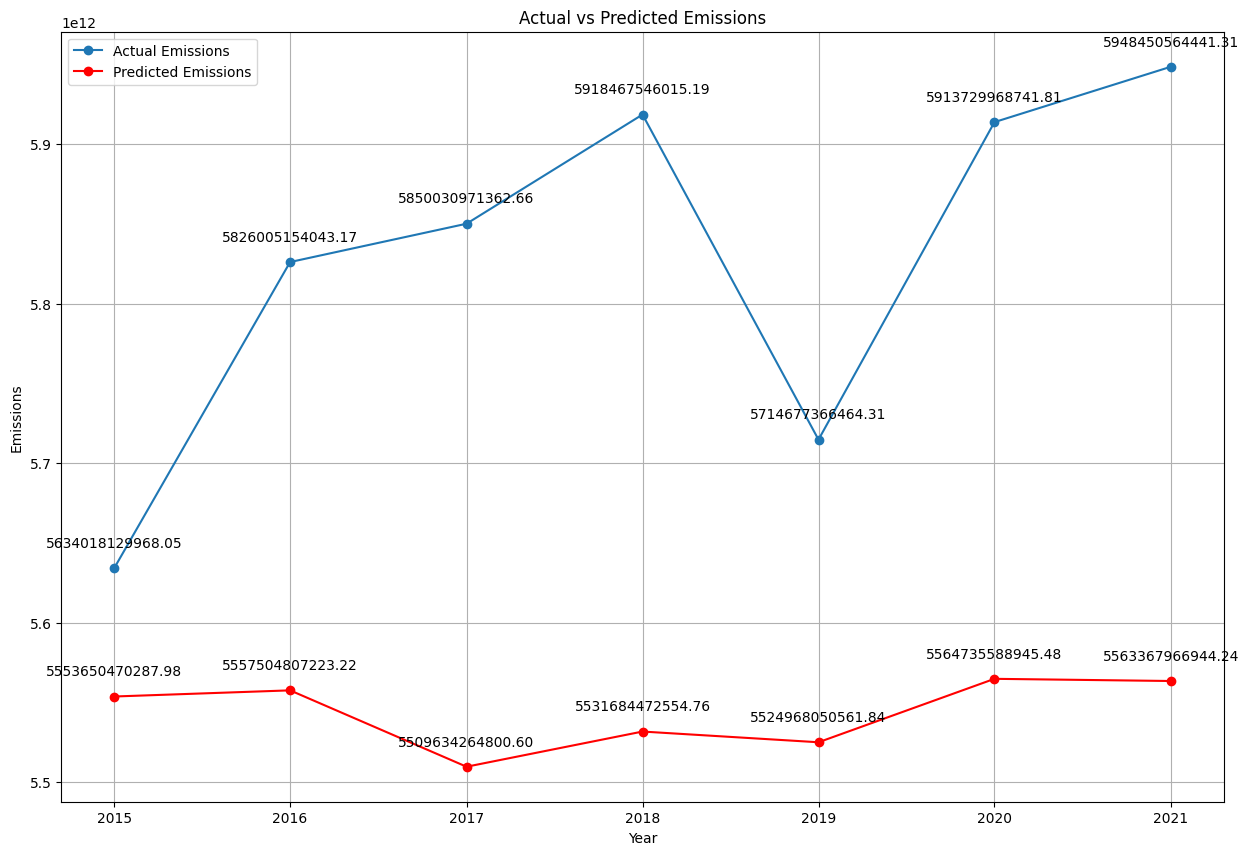

In [20]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_arima_model1(df, train_size=0.8, order=(4, 1, 4)):
    df_copy = preprocess_data(df)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            model = ARIMA(train['Emission'], order=order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None
    
    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end)
    
    # Konversi prediksi ke DataFrame
    predictions = pd.Series(predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_arima_model1(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}')
print(f'MSE Percentage Error: {mse_percentage:.4f}')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

def evaluate_arima_model_with_grid_search(df, train_size=0.8):
    p = q = range(1, 6)
    d = range(1, 6)
    pdq = list(itertools.product(p, d, q))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = evaluate_arima_model1(df, train_size=train_size, order=param)
                if result:
                    avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                    if rmse < best_rmse:
                        best_rmse, best_params_rmse = rmse, param
                    if mae < best_mae:
                        best_mae, best_params_mae = mae, param
                    if mse < best_mse:
                        best_mse, best_params_mse = mse, param
                    if mape < best_mape:
                        best_mape, best_params_mape = mape, param
                    if mspe < best_mspe:
                        best_mspe, best_params_mspe = mspe, param
                    if rmspe < best_rmspe:
                        best_rmspe, best_params_rmspe = rmspe, param
                    if aic < best_aic:
                        best_aic, best_params_aic = aic, param
                    if bic < best_bic:
                        best_bic, best_params_bic = bic, param
        except Exception as e:
            print(f"Error with parameters {param}: {e}")
            continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Contoh penggunaan 
best_params = evaluate_arima_model_with_grid_search(df_copy)
print(f'Optimal ARIMA parameters: {best_params}')

ValueError for parameters (2, 3, 5): LU decomposition error.
ValueError for parameters (3, 4, 5): LU decomposition error.
ValueError for parameters (4, 1, 5): LU decomposition error.
ValueError for parameters (4, 3, 5): LU decomposition error.
ValueError for parameters (4, 4, 5): LU decomposition error.
ValueError for parameters (5, 3, 5): LU decomposition error.
ValueError for parameters (5, 4, 4): LU decomposition error.
Best MAE: 95666371695.63365 with parameters: (5, 1, 4)
Best MSE: 1.1457408970395467e+22 with parameters: (1, 3, 1)
Best RMSE: 107039287041.7001 with parameters: (1, 3, 1)
Best MAPE: 1.6450249830491492 with parameters: (5, 1, 4)
Best MSPE: 0.0338356330389588 with parameters: (1, 3, 1)
Best RMSPE: 0.1839446466711081 with parameters: (1, 3, 1)
Best AIC: 22.0 with parameters: (5, 1, 5)
Best BIC: 34.9585921338274 with parameters: (5, 1, 5)
Optimal ARIMA parameters: (1, 3, 1)


In [22]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction2(df, steps=9):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    # Normalisasi data
    df_copy, mean, std = normalize_data_diff(df_copy)

    model = ARIMA(df_copy['Emission_diff'], order=(4, 1, 4))
    model_fit = model.fit()

    # Prediksi differencing
    diff_predictions = model_fit.forecast(steps=steps)

    # Ambil nilai emisi terakhir sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[-1]

    # Kembalikan prediksi ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        # Denormalisasi differenced predictions
        diff_denormalized = (diff * std) + mean
        current_value += diff_denormalized
        absolute_predictions.append(current_value)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, absolute_predictions

# Contoh penggunaan fungsi
forecast_years, absolute_predictions = emission_prediction2(df_copy)
for year, emission in zip(forecast_years, absolute_predictions):
    print(f'Year: {year} with forecasted emission: {emission}')

C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


Year: 2022 with forecasted emission: 5891713425177.732
Year: 2023 with forecasted emission: 5955097557544.729
Year: 2024 with forecasted emission: 6061594753963.435
Year: 2025 with forecasted emission: 6073713219219.089
Year: 2026 with forecasted emission: 6061920682084.749
Year: 2027 with forecasted emission: 6116830383709.461
Year: 2028 with forecasted emission: 6187014615536.903
Year: 2029 with forecasted emission: 6212167467571.588
Year: 2030 with forecasted emission: 6226681277709.753


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 46889860481.322266
Mean Squared Error (MSE): 5.599705009547497e+21
Root Mean Squared Error (RMSE): 74831176721.65457
MAE Percentage Error: 0.8044
MSE Percentage Error: 96060704137.5890
RMSE Percentage Error: 1.2837
MAPE: 0.8053%
MSPE: 0.0163%
RMSPE: 0.1278%
AIC: 94.4718
BIC: 105.0743


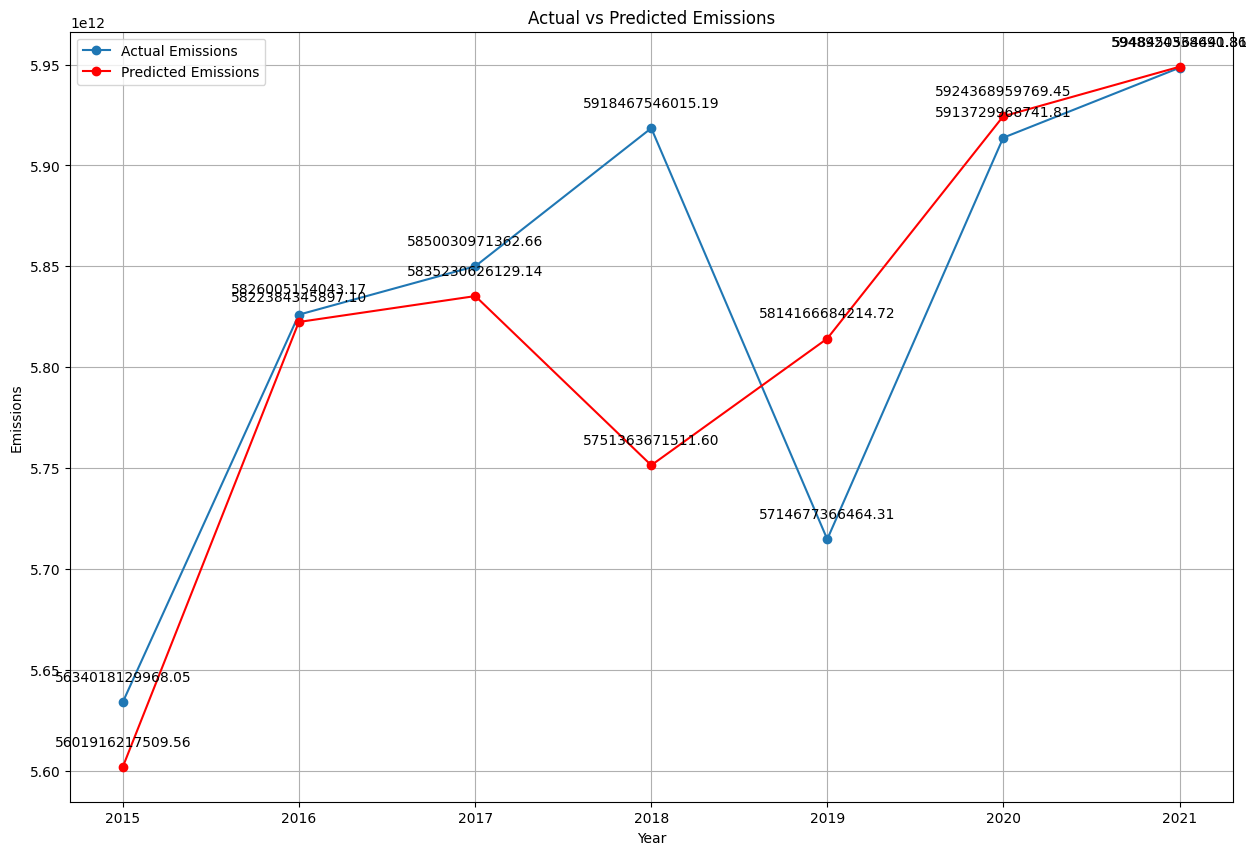

In [23]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_arima_model2(df, train_size=0.8, order=(4, 1, 4)):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Normalisasi data menggunakan statistik dari train set
    train, train_mean, train_std = normalize_data_diff(train)
    test, _, _ = normalize_data_diff(test, train_mean, train_std)
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            model = ARIMA(train['Emission_diff'], order=order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None
    
    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    diff_predictions = model_fit.predict(start=start, end=end)

    # Ambil nilai emisi terakhir dari train set sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[train_size - 1]

    # Konversi prediksi differenced ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        diff_denormalized = (diff * train_std) + train_mean
        current_value += diff_denormalized  # De-normalize difference
        absolute_predictions.append(current_value)

    # Konversi prediksi ke DataFrame
    predictions = pd.Series(absolute_predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_arima_model2(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}')
print(f'MSE Percentage Error: {mse_percentage:.4f}')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

def evaluate_arima_model_with_grid_search(df, train_size=0.8):
    p = q = range(1, 6)
    d = range(1, 5)
    pdq = list(itertools.product(p, d, q))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = evaluate_arima_model2(df, train_size=train_size, order=param)
                if result:
                    avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                    if rmse < best_rmse:
                        best_rmse, best_params_rmse = rmse, param
                    if mae < best_mae:
                        best_mae, best_params_mae = mae, param
                    if mse < best_mse:
                        best_mse, best_params_mse = mse, param
                    if mape < best_mape:
                        best_mape, best_params_mape = mape, param
                    if mspe < best_mspe:
                        best_mspe, best_params_mspe = mspe, param
                    if rmspe < best_rmspe:
                        best_rmspe, best_params_rmspe = rmspe, param
                    if aic < best_aic:
                        best_aic, best_params_aic = aic, param
                    if bic < best_bic:
                        best_bic, best_params_bic = bic, param
        except Exception as e:
            print(f"Error with parameters {param}: {e}")
            continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Contoh penggunaan (Pastikan df sudah diinisiasi sebelumnya)
best_params = evaluate_arima_model_with_grid_search(df_copy)
print(f'Optimal ARIMA parameters: {best_params}')

ValueError for parameters (5, 2, 5): LU decomposition error.
Best MAE: 46889860481.322266 with parameters: (4, 1, 4)
Best MSE: 5.599705009547497e+21 with parameters: (4, 1, 4)
Best RMSE: 74831176721.65457 with parameters: (4, 1, 4)
Best MAPE: 0.8053107636745888 with parameters: (4, 1, 4)
Best MSPE: 0.016325151158583826 with parameters: (4, 1, 4)
Best RMSPE: 0.12776991491968612 with parameters: (4, 1, 4)
Best AIC: 29.42136026599555 with parameters: (4, 4, 4)
Best BIC: 38.822062205506356 with parameters: (4, 4, 4)
Optimal ARIMA parameters: (4, 1, 4)


In [25]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction3(df, steps=9):
    df_copy = preprocess_data(df)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    # Normalisasi data
    df_copy, mean, std = normalize_data(df_copy)

    model = ARIMA(df_copy['Emission'], order=(4, 2, 4))
    model_fit = model.fit()

    # Prediksi emisi untuk tahun ke depan
    forecast = model_fit.forecast(steps=steps)

    # Denormalisasi hasil prediksi
    forecast = denormalize_data(forecast, mean, std)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, forecast

forecast_years, forecast = emission_prediction3(df_copy)
for year, emission in zip(forecast_years, forecast):
    print(f'Year: {year} with forecasted emission: {emission}')

Year: 2022 with forecasted emission: 5893287434796.45
Year: 2023 with forecasted emission: 5956908265930.091
Year: 2024 with forecasted emission: 6061967968499.113
Year: 2025 with forecasted emission: 6074704931811.375
Year: 2026 with forecasted emission: 6064519142221.569
Year: 2027 with forecasted emission: 6118572911991.358
Year: 2028 with forecasted emission: 6187627240216.906
Year: 2029 with forecasted emission: 6214206160595.499
Year: 2030 with forecasted emission: 6229960663526.76


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 47863800297.98256
Mean Squared Error (MSE): 5.687012102767303e+21
Root Mean Squared Error (RMSE): 75412280848.46196
MAE Percentage Error: 0.8211
MSE Percentage Error: 97558422470.3586
RMSE Percentage Error: 1.2937
MAPE: 0.8222%
MSPE: 0.0166%
RMSPE: 0.1287%
AIC: 60.3849
BIC: 70.6043


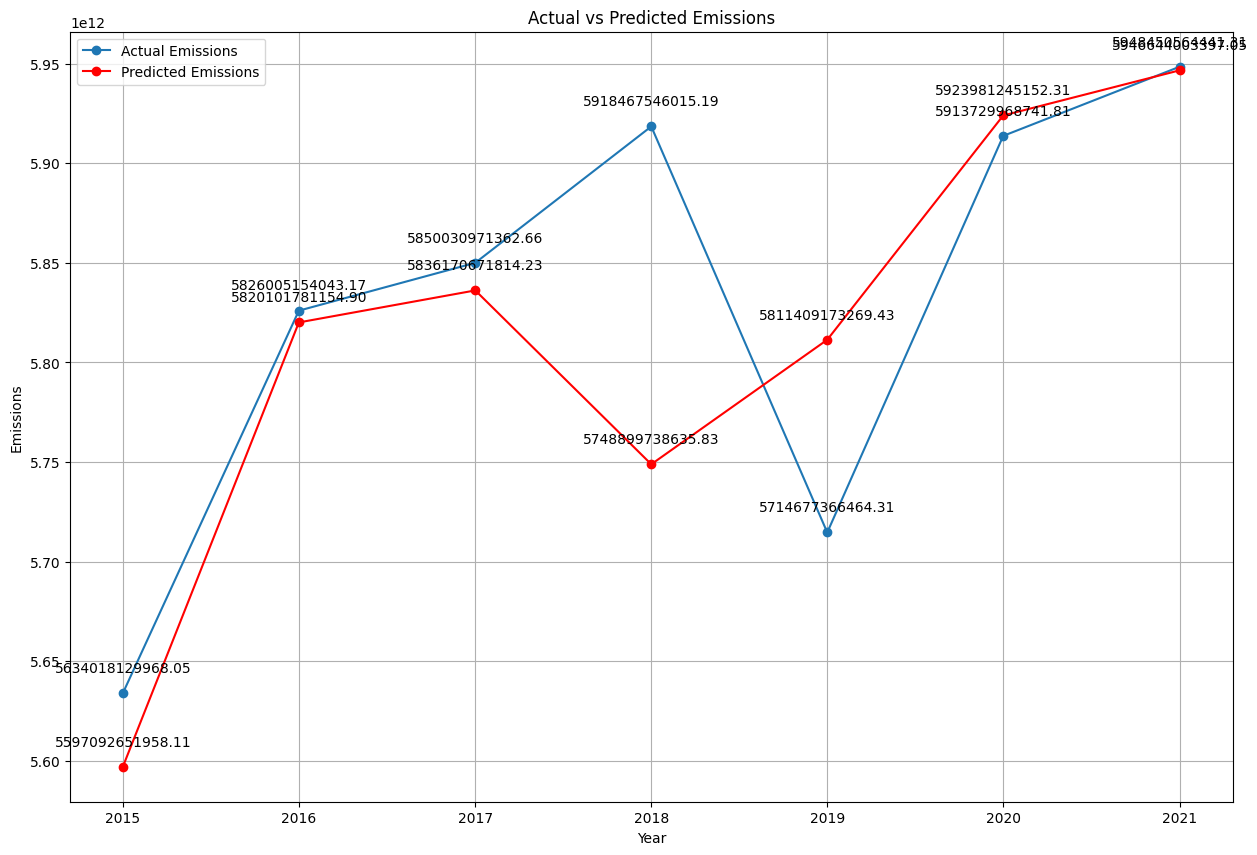

In [26]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_arima_model3(df, train_size=0.8, order=(4, 2, 4)):
    df_copy = preprocess_data(df)

    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy.iloc[:train_size], df_copy.iloc[train_size:]
    
    # Normalisasi data menggunakan statistik dari train set
    train, train_mean, train_std = normalize_data(train)
    test, _, _ = normalize_data(test, train_mean, train_std)
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            model = ARIMA(train['Emission'], order=order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None

    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end)
    
    # Denormalisasi data
    predictions = denormalize_data(predictions, train_mean, train_std)
    test['Emission'] = denormalize_data(test['Emission'], train_mean, train_std)
    
    # Konversi prediksi ke DataFrame
    predictions = pd.Series(predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_arima_model3(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}')
print(f'MSE Percentage Error: {mse_percentage:.4f}')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

def evaluate_arima_model_with_grid_search(df, train_size=0.8):
    p = q = range(1, 6)
    d = range(1, 5)
    pdq = list(itertools.product(p, d, q))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = evaluate_arima_model3(df, train_size=train_size, order=param)
                if result:
                    avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                    if rmse < best_rmse:
                        best_rmse, best_params_rmse = rmse, param
                    if mae < best_mae:
                        best_mae, best_params_mae = mae, param
                    if mse < best_mse:
                        best_mse, best_params_mse = mse, param
                    if mape < best_mape:
                        best_mape, best_params_mape = mape, param
                    if mspe < best_mspe:
                        best_mspe, best_params_mspe = mspe, param
                    if rmspe < best_rmspe:
                        best_rmspe, best_params_rmspe = rmspe, param
                    if aic < best_aic:
                        best_aic, best_params_aic = aic, param
                    if bic < best_bic:
                        best_bic, best_params_bic = bic, param
        except Exception as e:
            print(f"Error with parameters {param}: {e}")
            continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Contoh penggunaan (Pastikan df sudah diinisiasi sebelumnya)
best_params = evaluate_arima_model_with_grid_search(df_copy)
print(f'Optimal ARIMA parameters: {best_params}')

ValueError for parameters (3, 4, 5): LU decomposition error.
Best MAE: 47863800297.98256 with parameters: (4, 2, 4)
Best MSE: 5.687012102767303e+21 with parameters: (4, 2, 4)
Best RMSE: 75412280848.46196 with parameters: (4, 2, 4)
Best MAPE: 0.8221611080069368 with parameters: (4, 2, 4)
Best MSPE: 0.016572444563621013 with parameters: (4, 2, 4)
Best RMSPE: 0.1287340070207597 with parameters: (4, 2, 4)
Best AIC: 16.0 with parameters: (2, 3, 5)
Best BIC: 24.72833962686653 with parameters: (2, 3, 5)
Optimal ARIMA parameters: (4, 2, 4)


In [28]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction_sarimax(df, steps=9):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    # Normalisasi data
    df_copy, mean, std = normalize_data_diff(df_copy)

    model = SARIMAX(df_copy['Emission_diff'], order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit()

    # Prediksi differencing
    diff_predictions = model_fit.forecast(steps=steps)

    # Ambil nilai emisi terakhir sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[-1]

    # Kembalikan prediksi ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        # Denormalisasi differenced predictions
        diff_denormalized = (diff * std) + mean
        current_value += diff_denormalized
        absolute_predictions.append(current_value)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, absolute_predictions

# Contoh penggunaan fungsi
forecast_years, absolute_predictions = emission_prediction_sarimax(df_copy)
for year, emission in zip(forecast_years, absolute_predictions):
    print(f'Year: {year} with forecasted emission: {emission}')

C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameter

Year: 2022 with forecasted emission: 5822868447491.584
Year: 2023 with forecasted emission: 5893168607845.758
Year: 2024 with forecasted emission: 6203323597138.1875
Year: 2025 with forecasted emission: 5945379667536.404
Year: 2026 with forecasted emission: 6109071769012.5
Year: 2027 with forecasted emission: 6149040024100.445
Year: 2028 with forecasted emission: 6113379347535.687
Year: 2029 with forecasted emission: 6168920276821.46
Year: 2030 with forecasted emission: 6206675016489.054


C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 66477882988.476845
Mean Squared Error (MSE): 5.507252507025595e+21
Root Mean Squared Error (RMSE): 74210865154.81136
MAE Percentage Error: 1.1404%
MSE Percentage Error: 94474718362.1966%
RMSE Percentage Error: 1.2731%
MAPE: 1.1378%
MSPE: 0.0162%
RMSPE: 0.1271%
AIC: 91.5751
BIC: 99.8215


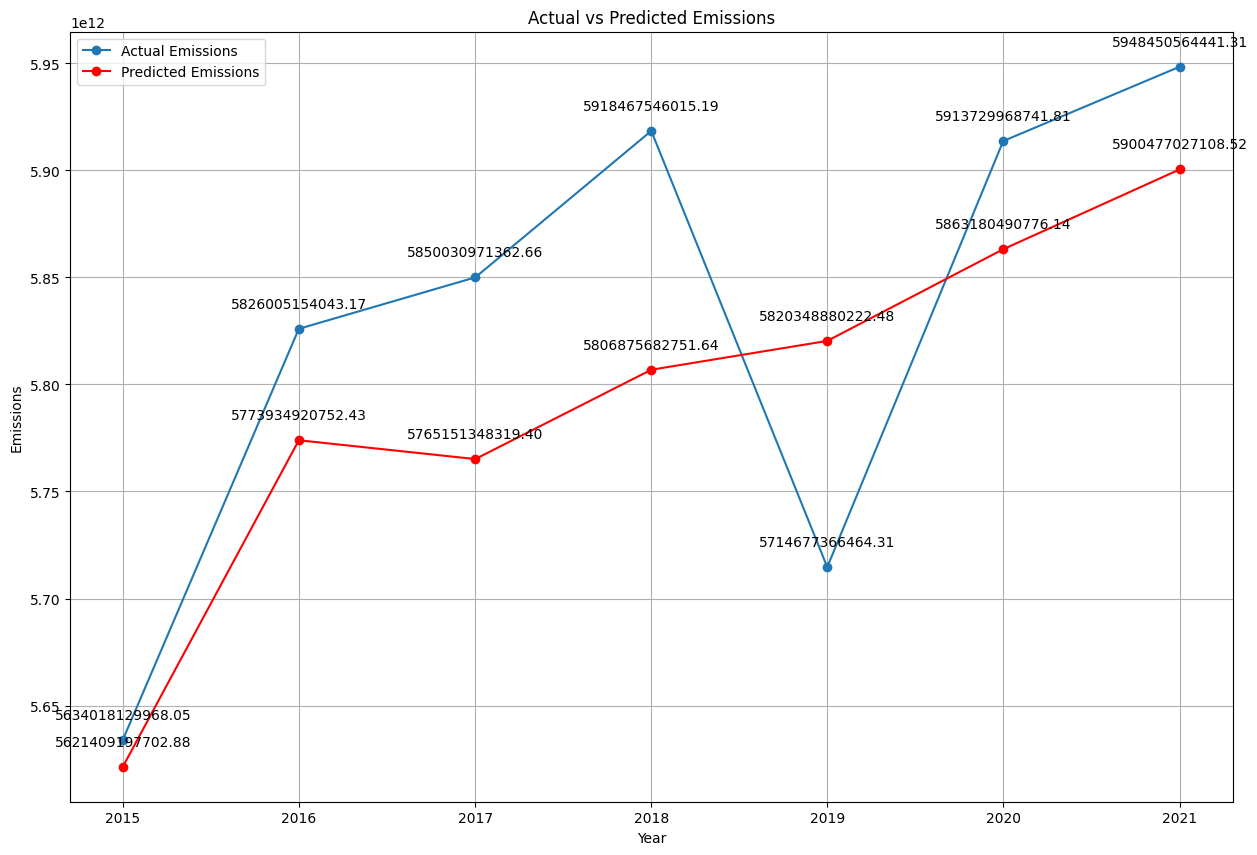

In [29]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_sarimax_model(df, train_size=0.8, order=(2, 1, 2), seasonal_order=(1, 0, 1, 12)):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Normalisasi data menggunakan statistik dari train set
    train, train_mean, train_std = normalize_data_diff(train)
    test, _, _ = normalize_data_diff(test, train_mean, train_std)
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SARIMAX(train['Emission_diff'], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None
    
    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    diff_predictions = model_fit.predict(start=start, end=end)

    # Ambil nilai emisi terakhir dari train set sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[train_size - 1]

    # Konversi prediksi differenced ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        diff_denormalized = (diff * train_std) + train_mean
        current_value += diff_denormalized  # De-normalize difference
        absolute_predictions.append(current_value)

    # Konversi prediksi ke DataFrame
    predictions = pd.Series(absolute_predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_sarimax_model(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}%')
print(f'MSE Percentage Error: {mse_percentage:.4f}%')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}%')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Grid search for best SARIMA parameters
def evaluate_sarimax_model_with_grid_search(df, train_size=0.8):
    p = d = q = range(0, 3)
    P = D = Q = range(0, 2)
    s = [12]  # Assuming monthly data with yearly seasonality
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = evaluate_sarimax_model(df, train_size=train_size, order=param, seasonal_order=seasonal_param)
                    if result:
                        avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                        if rmse < best_rmse:
                            best_rmse, best_params_rmse = rmse, (param, seasonal_param)
                        if mae < best_mae:
                            best_mae, best_params_mae = mae, (param, seasonal_param)
                        if mse < best_mse:
                            best_mse, best_params_mse = mse, (param, seasonal_param)
                        if mape < best_mape:
                            best_mape, best_params_mape = mape, (param, seasonal_param)
                        if mspe < best_mspe:
                            best_mspe, best_params_mspe = mspe, (param, seasonal_param)
                        if rmspe < best_rmspe:
                            best_rmspe, best_params_rmspe = rmspe, (param, seasonal_param)
                        if aic < best_aic:
                            best_aic, best_params_aic = aic, (param, seasonal_param)
                        if bic < best_bic:
                            best_bic, best_params_bic = bic, (param, seasonal_param)
            except Exception as e:
                print(f"Error with parameters {param} {seasonal_param}: {e}")
                continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Example usage (make sure df is initialized properly)
best_params = evaluate_sarimax_model_with_grid_search(df_copy)
print(f'Optimal SARIMAX parameters: {best_params}')

Best MAE: 58978624087.011856 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best MSE: 5.507252507025595e+21 with parameters: ((2, 1, 2), (1, 0, 1, 12))
Best RMSE: 74210865154.81136 with parameters: ((2, 1, 2), (1, 0, 1, 12))
Best MAPE: 1.0166816313086846 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best MSPE: 0.016156378396166925 with parameters: ((2, 1, 2), (1, 0, 1, 12))
Best RMSPE: 0.12710774325809945 with parameters: ((2, 1, 2), (1, 0, 1, 12))
Best AIC: 56.109519611371105 with parameters: ((0, 0, 0), (0, 1, 0, 12))
Best BIC: 56.67446896883264 with parameters: ((0, 0, 0), (0, 1, 0, 12))
Optimal SARIMAX parameters: ((2, 1, 2), (1, 0, 1, 12))


In [31]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction_sarimax1(df, steps=9):
    df_copy = preprocess_data(df)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    model = SARIMAX(df_copy['Emission'], order=(1, 0, 2), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit()

    # Prediksi emisi untuk tahun ke depan
    forecast = model_fit.forecast(steps=steps)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, forecast

forecast_years, forecast = emission_prediction_sarimax1(df_copy)
for year, emission in zip(forecast_years, forecast):
    print(f'Year: {year} with forecasted emission: {emission}')


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 

Year: 2022 with forecasted emission: 5929354317500.405
Year: 2023 with forecasted emission: 5930925096738.741
Year: 2024 with forecasted emission: 5961616887432.918
Year: 2025 with forecasted emission: 5941641769397.498
Year: 2026 with forecasted emission: 5895591405806.24
Year: 2027 with forecasted emission: 5962455839054.019
Year: 2028 with forecasted emission: 5913834906149.614
Year: 2029 with forecasted emission: 5866320533920.916
Year: 2030 with forecasted emission: 5765625104198.619


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 90078759082.44168
Mean Squared Error (MSE): 9.950507683935825e+21
Root Mean Squared Error (RMSE): 99752231473.46542
MAE Percentage Error: 1.5453%
MSE Percentage Error: 170696987254.7994%
RMSE Percentage Error: 1.7112%
MAPE: 1.5434%
MSPE: 0.0290%
RMSPE: 0.1704%
AIC: 1403.0226
BIC: 1410.3359


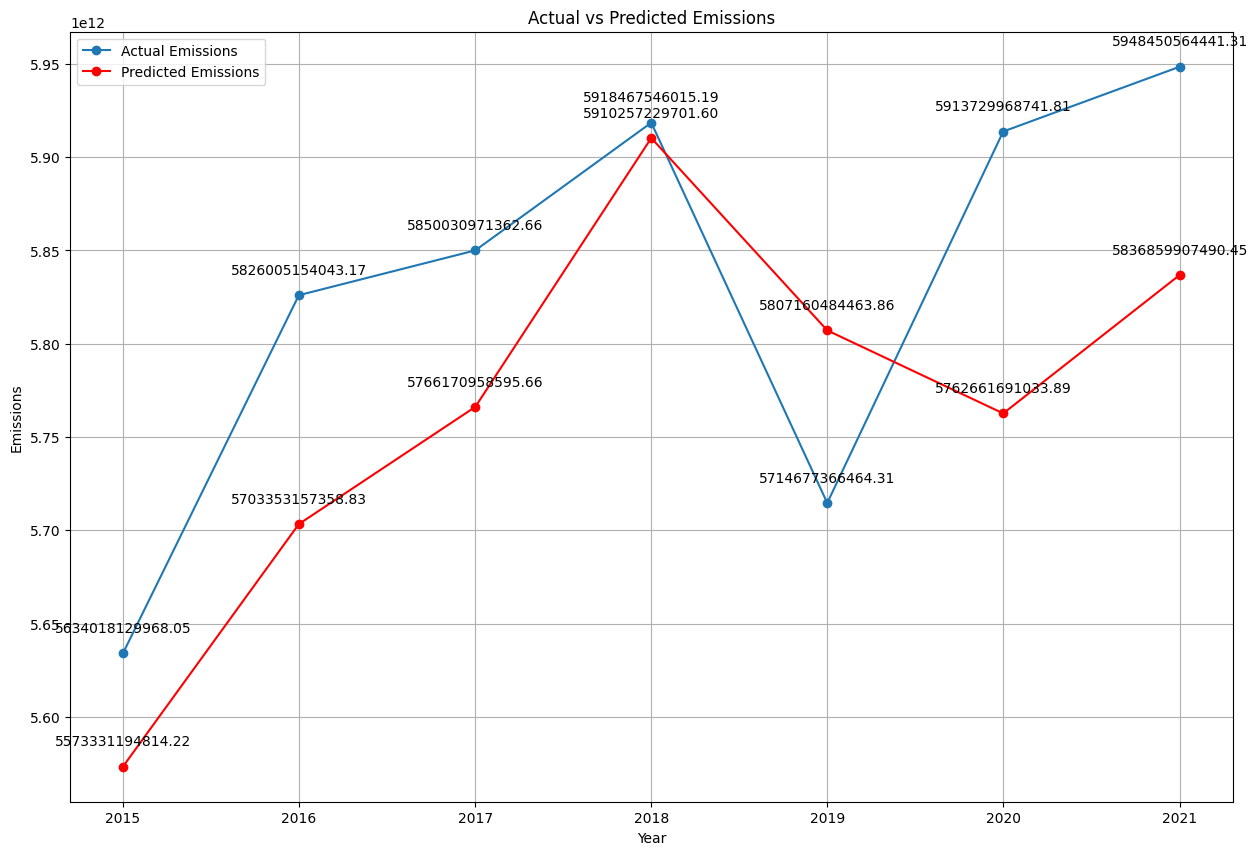

In [32]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

df_copy = copy_and_convert_to_float(df)
# Function to evaluate ARIMA model
def evaluate_sarimax_model1(df, train_size=0.8, order=(1, 0, 2), seasonal_order=(1, 0, 1, 12)):
    df_copy = preprocess_data(df)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy.iloc[:train_size], df_copy.iloc[train_size:]
    
    # Fit SARIMA model
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SARIMAX(train['Emission'], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
    except ValueError as ve:
        print(f"ValueError for parameters {order}, {seasonal_order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}, {seasonal_order}: {lae}")
        return None
    
    # Predict test data
    start = len(train)
    end = start + len(test) - 1
    if end < start:
        end = start

    predictions = model_fit.predict(start=start, end=end)
    # Konversi prediksi ke DataFrame
    predictions = pd.Series(predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_sarimax_model1(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}%')
print(f'MSE Percentage Error: {mse_percentage:.4f}%')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}%')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Grid search for best SARIMA parameters
def evaluate_sarimax_model_with_grid_search(df, train_size=0.8):
    p = d = q = range(0, 3)
    P = D = Q = range(0, 2)
    s = [12]  # Assuming monthly data with yearly seasonality
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = evaluate_sarimax_model1(df, train_size=train_size, order=param, seasonal_order=seasonal_param)
                    if result:
                        avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                        if rmse < best_rmse:
                            best_rmse, best_params_rmse = rmse, (param, seasonal_param)
                        if mae < best_mae:
                            best_mae, best_params_mae = mae, (param, seasonal_param)
                        if mse < best_mse:
                            best_mse, best_params_mse = mse, (param, seasonal_param)
                        if mape < best_mape:
                            best_mape, best_params_mape = mape, (param, seasonal_param)
                        if mspe < best_mspe:
                            best_mspe, best_params_mspe = mspe, (param, seasonal_param)
                        if rmspe < best_rmspe:
                            best_rmspe, best_params_rmspe = rmspe, (param, seasonal_param)
                        if aic < best_aic:
                            best_aic, best_params_aic = aic, (param, seasonal_param)
                        if bic < best_bic:
                            best_bic, best_params_bic = bic, (param, seasonal_param)
            except Exception as e:
                print(f"Error with parameters {param} {seasonal_param}: {e}")
                continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Example usage (make sure df is initialized properly)
best_params = evaluate_sarimax_model_with_grid_search(df_copy)
print(f'Optimal SARIMAX parameters: {best_params}')

Best MAE: 90078759082.44168 with parameters: ((1, 0, 2), (1, 0, 1, 12))
Best MSE: 9.950507683935825e+21 with parameters: ((1, 0, 2), (1, 0, 1, 12))
Best RMSE: 99752231473.46542 with parameters: ((1, 0, 2), (1, 0, 1, 12))
Best MAPE: 1.543351842721674 with parameters: ((1, 0, 2), (1, 0, 1, 12))
Best MSPE: 0.02904344107412409 with parameters: ((1, 0, 2), (1, 0, 1, 12))
Best RMSPE: 0.17042136331494384 with parameters: ((1, 0, 2), (1, 0, 1, 12))
Best AIC: 618.2710523227133 with parameters: ((0, 2, 2), (0, 1, 0, 12))
Best BIC: 619.4647381411085 with parameters: ((0, 2, 2), (0, 1, 0, 12))
Optimal SARIMAX parameters: ((1, 0, 2), (1, 0, 1, 12))


In [34]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction_sarimax2(df, steps=9):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    model = SARIMAX(df_copy['Emission_diff'], order=(2, 1, 1), seasonal_order=(0, 0, 0, 12))
    model_fit = model.fit()

    # Prediksi differencing
    diff_predictions = model_fit.forecast(steps=steps)

    # Ambil nilai emisi terakhir sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[-1]

    # Kembalikan prediksi ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        # Denormalisasi differenced predictions
        current_value += diff
        absolute_predictions.append(current_value)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, absolute_predictions

# Contoh penggunaan fungsi
forecast_years, absolute_predictions = emission_prediction_sarimax2(df_copy)
for year, emission in zip(forecast_years, absolute_predictions):
    print(f'Year: {year} with forecasted emission: {emission}')

C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


Year: 2022 with forecasted emission: 5927813443771.802
Year: 2023 with forecasted emission: 5993655206109.541
Year: 2024 with forecasted emission: 6033344085325.244
Year: 2025 with forecasted emission: 6056597184329.024
Year: 2026 with forecasted emission: 6097623385206.906
Year: 2027 with forecasted emission: 6135040608819.567
Year: 2028 with forecasted emission: 6168151272190.306
Year: 2029 with forecasted emission: 6204786555546.046
Year: 2030 with forecasted emission: 6241071686964.862


C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission'].dropna(), regression='c')
C:\Users\ACER\AppData\Local\Temp\ipykernel_32236\1641775815.py:86: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result = kpss(df_copy['Emission_diff'].dropna(), regression='c')


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 60973555393.1663
Mean Squared Error (MSE): 6.426583706114705e+21
Root Mean Squared Error (RMSE): 80165975988.03812
MAE Percentage Error: 1.0460%
MSE Percentage Error: 110245478102.1441%
RMSE Percentage Error: 1.3752%
MAPE: 1.0503%
MSPE: 0.0192%
RMSPE: 0.1385%
AIC: 1338.6085
BIC: 1343.3207


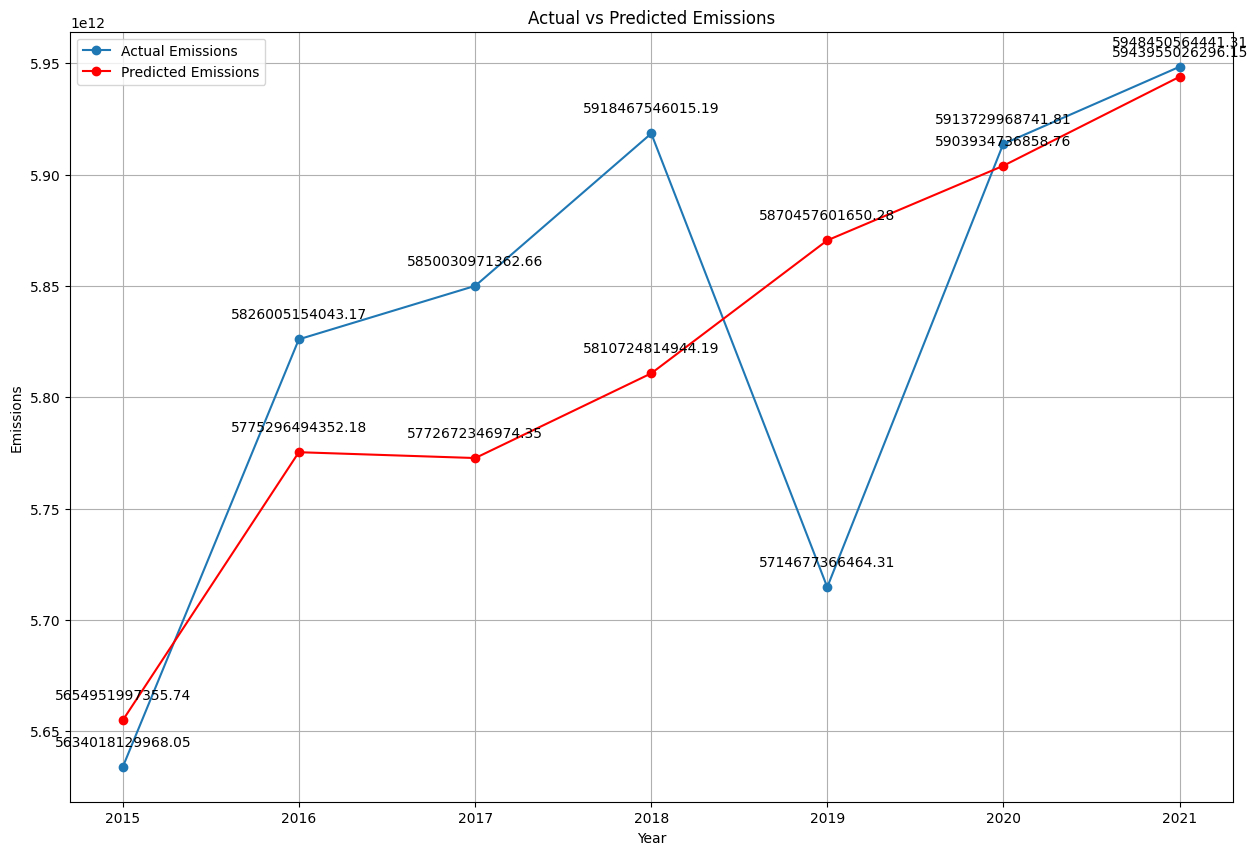

In [35]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_sarimax_model2(df, train_size=0.8, order=(2, 1, 1), seasonal_order=(0, 0, 0, 12)):
    df_copy = preprocess_data(df)
    df_copy = make_stationary(df_copy)
    
    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SARIMAX(train['Emission_diff'], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None
    
    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    diff_predictions = model_fit.predict(start=start, end=end)

    # Ambil nilai emisi terakhir dari train set sebelum differencing
    last_actual_value = df_copy['Emission'].iloc[train_size - 1]

    # Konversi prediksi differenced ke nilai absolut
    absolute_predictions = []
    current_value = last_actual_value

    for diff in diff_predictions:
        current_value += diff
        absolute_predictions.append(current_value)

    # Konversi prediksi ke DataFrame
    predictions = pd.Series(absolute_predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_sarimax_model2(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}%')
print(f'MSE Percentage Error: {mse_percentage:.4f}%')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}%')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Grid search for best SARIMA parameters
def evaluate_sarimax_model_with_grid_search(df, train_size=0.8):
    p = d = q = range(0, 3)
    P = D = Q = range(0, 2)
    s = [12]  # Assuming monthly data with yearly seasonality
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = evaluate_sarimax_model2(df, train_size=train_size, order=param, seasonal_order=seasonal_param)
                    if result:
                        avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                        if rmse < best_rmse:
                            best_rmse, best_params_rmse = rmse, (param, seasonal_param)
                        if mae < best_mae:
                            best_mae, best_params_mae = mae, (param, seasonal_param)
                        if mse < best_mse:
                            best_mse, best_params_mse = mse, (param, seasonal_param)
                        if mape < best_mape:
                            best_mape, best_params_mape = mape, (param, seasonal_param)
                        if mspe < best_mspe:
                            best_mspe, best_params_mspe = mspe, (param, seasonal_param)
                        if rmspe < best_rmspe:
                            best_rmspe, best_params_rmspe = rmspe, (param, seasonal_param)
                        if aic < best_aic:
                            best_aic, best_params_aic = aic, (param, seasonal_param)
                        if bic < best_bic:
                            best_bic, best_params_bic = bic, (param, seasonal_param)
            except Exception as e:
                print(f"Error with parameters {param} {seasonal_param}: {e}")
                continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Example usage (make sure df is initialized properly)
best_params = evaluate_sarimax_model_with_grid_search(df_copy)
print(f'Optimal SARIMAX parameters: {best_params}')

Best MAE: 60973555393.1663 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best MSE: 6.426583706114705e+21 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best RMSE: 80165975988.03812 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best MAPE: 1.0502766841350526 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best MSPE: 0.019174789463120536 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best RMSPE: 0.13847306403456427 with parameters: ((2, 1, 1), (0, 0, 0, 12))
Best AIC: 617.2986780285581 with parameters: ((1, 2, 2), (1, 1, 1, 12))
Best BIC: 619.6860496653484 with parameters: ((1, 2, 2), (1, 1, 1, 12))
Optimal SARIMAX parameters: ((2, 1, 1), (0, 0, 0, 12))


In [37]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Menggunakan model ARIMA untuk prediksi emisi
def emission_prediction_sarimax3(df, steps=9):

    df_copy = preprocess_data(df)

    # Convert 'Year' to datetime and set as index with a specified frequency
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'

    # Normalisasi data
    df_copy, mean, std = normalize_data(df_copy)

    model = SARIMAX(df_copy['Emission'], order=(2, 2, 2), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit()

    # Prediksi emisi untuk tahun ke depan
    forecast = model_fit.forecast(steps=steps)

    # Denormalisasi hasil prediksi
    forecast = denormalize_data(forecast, mean, std)

    forecast_years = np.arange(df_copy.index.year.max() + 1, df_copy.index.year.max() + 1 + steps)
    
    return forecast_years, forecast

# Contoh penggunaan fungsi
forecast_years, forecast = emission_prediction_sarimax3(df_copy)
for year, emission in zip(forecast_years, forecast):
    print(f'Year: {year} with forecasted emission: {emission}')

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Year: 2022 with forecasted emission: 5871933450000.42
Year: 2023 with forecasted emission: 5912661791773.226
Year: 2024 with forecasted emission: 6122714736323.917
Year: 2025 with forecasted emission: 5988509700991.243
Year: 2026 with forecasted emission: 6079044295386.915
Year: 2027 with forecasted emission: 6100363492413.906
Year: 2028 with forecasted emission: 6097365261858.058
Year: 2029 with forecasted emission: 6135806721734.465
Year: 2030 with forecasted emission: 6171766678449.857


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Avg actual: 5829339957290.929
Mean Absolute Error (MAE): 65996259020.956474
Mean Squared Error (MSE): 5.481323500826053e+21
Root Mean Squared Error (RMSE): 74035960862.44882
MAE Percentage Error: 1.1321%
MSE Percentage Error: 94029916611.2348%
RMSE Percentage Error: 1.2701%
MAPE: 1.1297%
MSPE: 0.0161%
RMSPE: 0.1269%
AIC: 57.4843
BIC: 65.4328


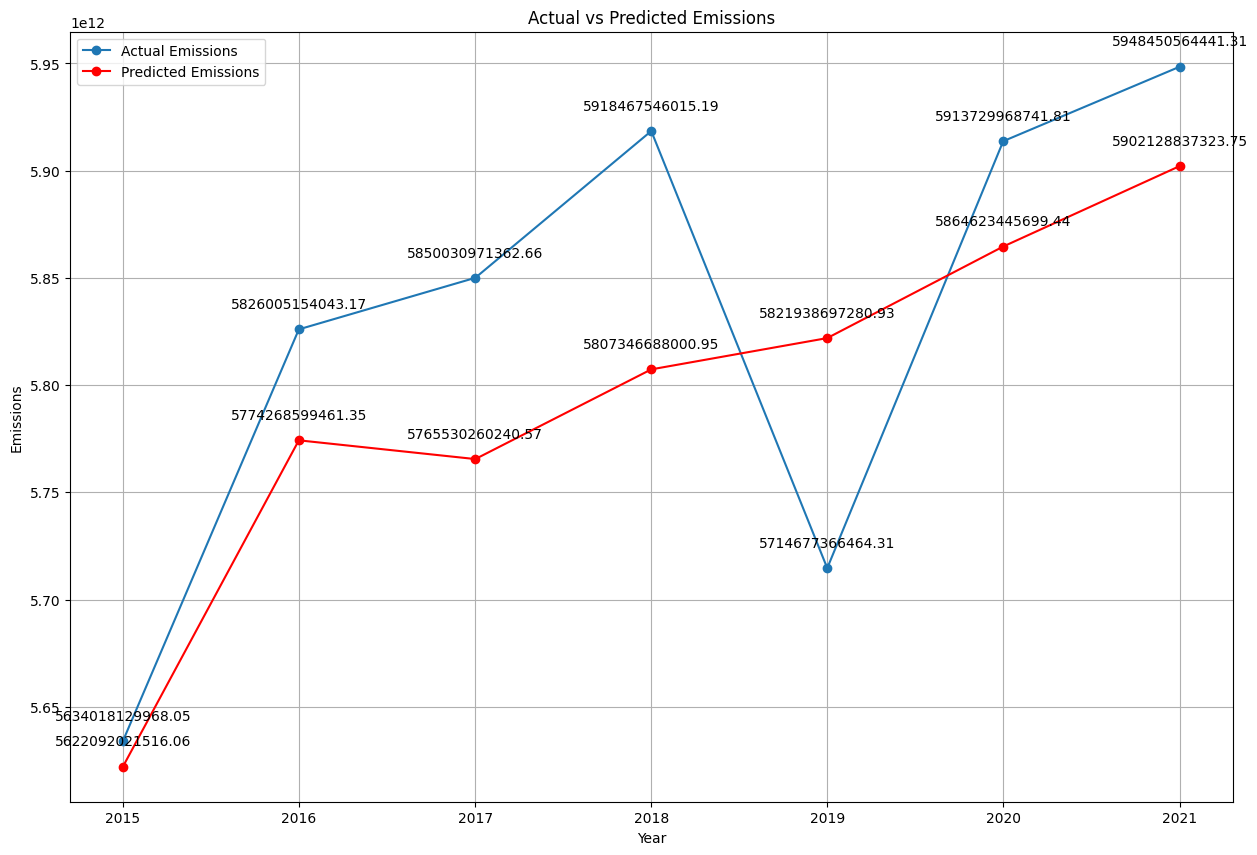

In [38]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Membuat evaluasi model ARIMA yang dibuat
def evaluate_sarimax_model3(df, train_size=0.8, order=(2, 2, 2), seasonal_order=(1, 0, 1, 12)):
    df_copy = preprocess_data(df)

    # Convert 'Year' to datetime and set as index
    df_copy['Year'] = pd.to_datetime(df_copy['Year'], format='%Y')
    df_copy.set_index('Year', inplace=True)
    df_copy = df_copy.asfreq('YS')  # Ensuring the frequency is 'Year Start'
    
    train_size = int(len(df_copy) * train_size)
    train, test = df_copy[:train_size], df_copy[train_size:]
    
    # Normalisasi data menggunakan statistik dari train set
    train, train_mean, train_std = normalize_data(train)
    test, _, _ = normalize_data(test, train_mean, train_std)
    
    # Isi model dengan training data
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = SARIMAX(train['Emission'], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
    except ValueError as ve:
        print(f"ValueError for parameters {order}: {ve}")
        return None
    except np.linalg.LinAlgError as lae:
        print(f"LinAlgError for parameters {order}: {lae}")
        return None

    # Prediksi test data
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end)
    
    # Denormalisasi data
    predictions = denormalize_data(predictions, train_mean, train_std)
    test['Emission'] = denormalize_data(test['Emission'], train_mean, train_std)
    
    # Konversi prediksi ke DataFrame
    predictions = pd.Series(predictions, index=test.index)
    
    # Kalkulasi eror
    mae = mean_absolute_error(test['Emission'], predictions)
    mse = mean_squared_error(test['Emission'], predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Emission'] - predictions) / test['Emission'])) * 100
    mspe = np.mean(((test['Emission'] - predictions) / test['Emission']) ** 2) * 100
    rmspe = np.sqrt(mspe)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Kalkulasi persentase eror
    avg_actual = np.mean(test['Emission'])
    mae_percentage = (mae / avg_actual) * 100
    mse_percentage = (mse / avg_actual) * 100
    rmse_percentage = (rmse / avg_actual) * 100
    
    return avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test.index, test['Emission'], predictions

# Contoh penggunaan
avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = evaluate_sarimax_model3(df_copy)
print("Avg actual:", avg_actual)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'MAE Percentage Error: {mae_percentage:.4f}%')
print(f'MSE Percentage Error: {mse_percentage:.4f}%')
print(f'RMSE Percentage Error: {rmse_percentage:.4f}%')
print(f"MAPE: {mape:.4f}%")
print(f"MSPE: {mspe:.4f}%")
print(f"RMSPE: {rmspe:.4f}%")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot asli dan prediksi (Gunakan hasil dari evaluate_arima_model)
plt.figure(figsize=(15, 10))
# Plot untuk actual emissions
plt.plot(test_years, actual, label='Actual Emissions', marker='o')
for i, value in enumerate(actual):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Plot untuk predicted emissions
plt.plot(test_years, predictions, label='Predicted Emissions', color='red', marker='o')
for i, value in enumerate(predictions):
    x_coord = test_years[i]
    y_coord = value
    plt.annotate(f'{y_coord:.2f}', (x_coord, y_coord), textcoords="offset points", xytext=(0, 15), ha='center')

# Pengaturan label dan judul
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Actual vs Predicted Emissions')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Grid search for best SARIMA parameters
def evaluate_sarimax_model_with_grid_search(df, train_size=0.8):
    p = d = q = range(0, 3)
    P = D = Q = range(0, 2)
    s = [12]  # Assuming monthly data with yearly seasonality
    
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))
    
    best_mae, best_params_mae = float("inf"), None
    best_mse, best_params_mse = float("inf"), None
    best_rmse, best_params_rmse = float("inf"), None
    best_mape, best_params_mape = float("inf"), None
    best_mspe, best_params_mspe = float("inf"), None
    best_rmspe, best_params_rmspe = float("inf"), None
    best_aic, best_params_aic = float("inf"), None
    best_bic, best_params_bic = float("inf"), None
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    result = evaluate_sarimax_model3(df, train_size=train_size, order=param, seasonal_order=seasonal_param)
                    if result:
                        avg_actual, mae, mse, rmse, mape, mspe, rmspe, aic, bic, mae_percentage, mse_percentage, rmse_percentage, test_years, actual, predictions = result
                        if rmse < best_rmse:
                            best_rmse, best_params_rmse = rmse, (param, seasonal_param)
                        if mae < best_mae:
                            best_mae, best_params_mae = mae, (param, seasonal_param)
                        if mse < best_mse:
                            best_mse, best_params_mse = mse, (param, seasonal_param)
                        if mape < best_mape:
                            best_mape, best_params_mape = mape, (param, seasonal_param)
                        if mspe < best_mspe:
                            best_mspe, best_params_mspe = mspe, (param, seasonal_param)
                        if rmspe < best_rmspe:
                            best_rmspe, best_params_rmspe = rmspe, (param, seasonal_param)
                        if aic < best_aic:
                            best_aic, best_params_aic = aic, (param, seasonal_param)
                        if bic < best_bic:
                            best_bic, best_params_bic = bic, (param, seasonal_param)
            except Exception as e:
                print(f"Error with parameters {param} {seasonal_param}: {e}")
                continue
    
    print(f'Best MAE: {best_mae} with parameters: {best_params_mae}')
    print(f'Best MSE: {best_mse} with parameters: {best_params_mse}')
    print(f'Best RMSE: {best_rmse} with parameters: {best_params_rmse}')
    print(f'Best MAPE: {best_mape} with parameters: {best_params_mape}')
    print(f'Best MSPE: {best_mspe} with parameters: {best_params_mspe}')
    print(f'Best RMSPE: {best_rmspe} with parameters: {best_params_rmspe}')
    print(f'Best AIC: {best_aic} with parameters: {best_params_aic}')
    print(f'Best BIC: {best_bic} with parameters: {best_params_bic}')
    return best_params_rmse

# Example usage (make sure df is initialized properly)
best_params = evaluate_sarimax_model_with_grid_search(df_copy)
print(f'Optimal SARIMAX parameters: {best_params}')

Best MAE: 58979348625.136856 with parameters: ((2, 2, 1), (0, 0, 0, 12))
Best MSE: 5.481323500826053e+21 with parameters: ((2, 2, 2), (1, 0, 1, 12))
Best RMSE: 74035960862.44882 with parameters: ((2, 2, 2), (1, 0, 1, 12))
Best MAPE: 1.0166947075798247 with parameters: ((2, 2, 1), (0, 0, 0, 12))
Best MSPE: 0.016091147128288956 with parameters: ((2, 2, 2), (1, 0, 1, 12))
Best RMSPE: 0.12685088540601108 with parameters: ((2, 2, 2), (1, 0, 1, 12))
Best AIC: 30.836378809429966 with parameters: ((0, 1, 0), (0, 1, 0, 12))
Best BIC: 31.321285459217968 with parameters: ((0, 1, 0), (0, 1, 0, 12))
Optimal SARIMAX parameters: ((2, 2, 2), (1, 0, 1, 12))


In [40]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Algoritma Greedy untuk memilih sektor guna mengurangi emisi
def greedy_priority_sectors(df, target_reduction):
    # copy dataframe asli dan masukkan ke dalam variabel agar tidak mengubah dataframe saat diproses
    df_copy = df.copy()
    # Hitung total emisi untuk setiap sektor dari tahun 1990-2021
    df_copy = df_copy.groupby('Sector').sum().loc[:, '1990':'2021']
    # Cleaning dataframe dan convert ke float
    df_copy = df_copy.apply(lambda col: col.map(lambda x: float(str(x).replace('.', '').replace(',', '.'))))
    # Jumlahkan data emisi dari setiap sektor  dengan menambahkan nilai pada seluruh baris dan urutkan secara descending
    sector_emission = df_copy.sum(axis=1)
    sorted_sectors = sector_emission.sort_values(ascending=False)

    # Prioritaskan sektor untuk intervensi hingga target tercapai
    priority_list = []
    total_emission_reduction = 0.0
    # Dari seluruh sektor, lakukan intervensi mulai dari sektor dengan emisi tertinggi hingga mencapai target pengurangan emisi
    for sector in sorted_sectors.index:
        if total_emission_reduction >= target_reduction:
            break
            # loop berakhir jika target tercapai
        total_emission_reduction += sorted_sectors[sector]
        # Total emisi mengalami counter sesuai sektor yang di intervensi
        priority_list.append((sector, sorted_sectors[sector]))
    
    return priority_list, total_emission_reduction
    # Kembalikan sektor yang di intervensi dan total pengurangan emisinya

target_reduction = 2e18
priority_sectors, total_reduction = greedy_priority_sectors(df_copy, target_reduction)

for sector, emission in priority_sectors:
    print(f'Sector: {sector} with total emission: {emission}')
print(f'Total emission reduction achieved: {total_reduction}')

Sector: Bunker Fuels  with total emission: 1.812092306452975e+17
Sector: Electricity/Heat  with total emission: 7.054835149218442e+16
Sector: Industrial Processes  with total emission: 4.885767889791664e+16
Sector: Transportation  with total emission: 4.781785728715498e+16
Sector: Agriculture  with total emission: 4.0401343874706376e+16
Sector: Energy  with total emission: 3.626547594265024e+16
Sector: Land-Use Change and Forestry with total emission: 3.4691123323306828e+16
Sector: Other Fuel Combustion  with total emission: 2.4763132284987816e+16
Sector: Manufacturing/Construction  with total emission: 2.2162548053426756e+16
Sector: Total excluding LUCF with total emission: 2.105306006880408e+16
Sector: Total including LUCF with total emission: 5266588088093941.0
Sector: Waste  with total emission: 1657240342619253.0
Sector: Fugitive Emissions  with total emission: 383077039350665.0
Sector: Building with total emission: 340953943604.0
Total emission reduction achieved: 5.3507704829444

In [41]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Algoritma Brute Force untuk mencari kombinasi terbaik dari negara, sumber, sektor, dan gas dengan emisi maksimum
def brute_force_max_emission(df):
    df_copy = df.copy()
    max_emission = 0  # Inisialisasi variabel untuk menyimpan emisi maksimum
    best_combination = None  # Inisialisasi variabel untuk menyimpan kombinasi terbaik
    
    # Iterasi melalui semua kombinasi unik dari seluruh kolom Country, Source, Sector, dan Gas
    for combination in product(df_copy['Country_Name'].unique(), df_copy['Source'].unique(), df_copy['Sector'].unique(), df_copy['Gas'].unique()):
        # Pilih subset data berdasarkan kombinasi saat ini (kombinasi kolom Country, Source, Sector, dan Gas)
        country, source, sector, gas = combination
        # Subset diisi dengan mencocokan kolom dari masing-masing subset dengan variabel yang sesuai untuk data yang relevan
        subset = df_copy[(df_copy['Country_Name'] == country) & (df_copy['Source'] == source) & (df_copy['Sector'] == sector) & (df_copy['Gas'] == gas)]
        
        # Hitung total emisi tahun 1990-2021 dari subset untuk kombinasi saat ini
        total_emission = subset.loc[:, '1990':'2021'].sum().sum()
        
        # Periksa apakah total emisi saat ini lebih besar dari emisi maksimum yang diketahui
        if total_emission > max_emission:
            # Simpan total emisi saat ini sebagai emisi maksimum dan kombinasi saat ini sebagai yang terbaik
            max_emission = total_emission
            best_combination = combination  

    return best_combination, max_emission

best_combination, max_emission = brute_force_max_emission(df_copy)
print(f'Best combination: {best_combination} with total emission: {max_emission}')

Best combination: ('Japan', 'Climate Watch', 'Energy ', 'N2O') with total emission: 266404183491.0


In [42]:
# Mengatur ulang peringatan
warnings.resetwarnings()
warnings.simplefilter("always")

# Masukkan dataframe yang di convert ke variabel
df_copy = copy_and_convert_to_float(df)

# Algoritma Dynamic Programming untuk menemukan subsequence dengan peningkatan emisi terbesar
def max_increasing_subsequence(emissions):
    # Menyimpan panjang data emisi
    n = len(emissions)
    # Kalau panjang emisi 0 kembalikan list kosong dan nilai 0
    if n == 0:
        return [], 0

    # Inisiasi dp dengan list berupa elemen 0 sebanyak n elemen
    dp = [0] * n
    # Inisiasi parent berupa elemen -1 sebanyak n elemen
    parent = [-1] * n

    # dp[i] akan menyimpan jumlah maksimum subsequence yang berakhir pada indeks i
    # parent[i] akan menyimpan indeks elemen sebelumnya list dp dalam subsequence yang membentuk jumlah maksimum

    # Update elemen list dp sesuai elemen list emissions
    for i in range(n):
        dp[i] = emissions[i]

    # Mengisi tabel dp dan parent untuk setiap elemen
    # Start dari 1 karena nilai awal dp[0] itu pasti emission[0]
    for i in range(1, n):
        for j in range(i):
            # Bandingkan setiap elemen sebelum index ke i dengan elemen index ke i
            if emissions[i] > emissions[j] and dp[i] < dp[j] + emissions[i]:
                # Jika elemen ke i lebih dari elemen ke j dan subsequence i kurang dari subsequence j + elemen emisi ke i
                dp[i] = dp[j] + emissions[i]
                # Update subsequence i dengan nilai subsequence j ditambah elemen emisi ke i
                parent[i] = j
                # perbarui index elemen sebelum i dengan j pada list parent

    # Temukan indeks maksimum dari dp
    max_index = 0
    for i in range(1, n):
        # Kalau index ke i pada dp nilainya lebih besar dari max_index dari dp, nilai max_index diperbarui
        if dp[i] > dp[max_index]:
            max_index = i

    # Lacak kembali subsequence dari parent array
    sequence = []
    # selama max_index bukan -1 (index pertama dari parent (parent[0]) -1, tidak berubah)
    while max_index != -1:
        # Masukkan max_index ke list sequence
        sequence.append(max_index)
        # perbarui nilai max_index dengan nilai parent[max_index]
        max_index = parent[max_index]

    # Balikkan urutan subsequence untuk mendapatkan urutan secara ascending
    sequence.reverse()
    # Kembalikan sequence dan elemen dp dengan index sequence terbesar (sequence paling kanan)
    return sequence, dp[sequence[-1]]

# Membuat dictionary untuk menyimpan data
results = {}

# Loop melalui setiap negara dalam dataframe
for country in df['Country_Name'].unique():
    # Filter data untuk negara saat ini
    country_data = df[df['Country_Name'] == country]
    # Loop melalui setiap sektor dalam dataframe
    for sector in country_data['Sector'].unique():
        # Filter data untuk sektor saat ini
        sector_data = country_data[country_data['Sector'] == sector]
        # Loop melalui setiap gas dalam dataframe
        for gas in sector_data['Gas'].unique():
            # Filter data untuk gas saat ini
            gas_data = sector_data[sector_data['Gas'] == gas]
            # Mengambil kolom tahun mulai dari kolom ke-6 dan seterusnya (mulai kolom 1990 dan seterusnya)
            years = gas_data.columns[5:]
            # Mengambil nilai emisi dan menggabungkan semua values dari kolom 1990-2021 menjadi 1 array (values setiap kolom tidak di dalam array terpisah, dijadikan 1 dimensi)
            emissions = gas_data[years].values.flatten()

            # Untuk debugging: Menampilkan data yang sedang diproses
            # print(f"Processing {country} - {sector} - {gas}")
            # print(f"Years: {years}")
            # print(f"Emissions: {emissions}")

            # Jika panjang emisi lebih dari 0, cari subsequence dengan peningkatan terbesar
            if len(emissions) > 0:
                subsequence, max_sum = max_increasing_subsequence(emissions)
                # Validasi subsequence agar hanya termasuk indeks tahun yang valid
                # Menampilkan elemen year pada index ke i dimana i adalah seluruh elemen dari subsequence jika i kurang dari panjang kolom year
                valid_subsequence = [years[i] for i in subsequence if i < len(years)]
                # Simpan hasil dalam dictionary result
                results[(country, sector, gas)] = {
                    # Menyimpan value berupa dictionary baru di dalam dictionary result
                    'subsequence': valid_subsequence,
                    # Key Subsequence diisi value valid_subsequence
                    'max_sum': max_sum
                    # Key max_sum diisi value max_sum
                }

# Menampilkan hasil
for key, value in results.items():
    # Memecah key dan menyimpan valuenya ke variabel country, sector, dan gas
    country, sector, gas = key
    print(f"Country: {country}, Sector: {sector}, Gas: {gas}")
    print(f"Years with increasing subsequence: {value['subsequence']}")
    print(f"Maximum increase in emissions: {value['max_sum']}\n")
    
print(f"Emission : {emission}")

Country: Afghanistan, Sector: Total excluding LUCF, Gas: All GHG
Years with increasing subsequence: ['2021']
Maximum increase in emissions: 3502918132,00

Country: Afghanistan, Sector: Total excluding LUCF, Gas: CO2
Years with increasing subsequence: ['2013']
Maximum increase in emissions: 940225,00

Country: Afghanistan, Sector: Total excluding LUCF, Gas: CH4
Years with increasing subsequence: ['1998']
Maximum increase in emissions: 9959927417,00

Country: Afghanistan, Sector: Total excluding LUCF, Gas: N2O
Years with increasing subsequence: ['2017']
Maximum increase in emissions: 5261997285,00

Country: Afghanistan, Sector: Total excluding LUCF, Gas: F-Gas
Years with increasing subsequence: ['2021']
Maximum increase in emissions: 1416726871,00

Country: Afghanistan, Sector: Total including LUCF, Gas: All GHG
Years with increasing subsequence: ['1995']
Maximum increase in emissions: 9792843435,00

Country: Afghanistan, Sector: Total including LUCF, Gas: CO2
Years with increasing subse